## Prequisites Notebook
This notebook contains the models, figures and plots used for the ICS assignment 1 report. In order for the code to run properly, we import a handful of libraries to assist us, such as `numpy`, `math`, `scipy`, `matplotlib`. In addition, to standardize the plots through the report, we use a colour scheme. Finally, we supress scientific notation for numpy arrays.

In [101]:
import numpy as np
import math
from scipy import fft
from scipy.linalg import eig
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)

colors = {
    'Susceptible': '#ffbe30',  
    'Exposed': '#fbcc98',      
    'Infected': '#d62728',     
    'Recovered': '#f857c1'     
}

For numerically integrating the SIR models and their variants, fourth-order Runge-Kunta is used, which is defined and implemented below. The implementation is based on the pseudo-code presented by Press et al. (2007) [1].

In [102]:
def RK4(f, current_state: tuple, step_size: float = 0.01) -> float:
    """Performs Runge-Kunta 4th Order for a Single Step

    Args:
        f (_type_): A function.
        current_state (tuple): Inputs to the functions applicable
        step_size (float, optional): The step size used in RK4. Defaults to 0.01.

    Returns:
        float: A new value, f(current_state+step_size)
    """    
    k1 = step_size * f(*current_state)

    k2 = step_size * f(
        *[current_state[i] + k1 * 0.5 for i in range(len(current_state))]
    )
    k3 = step_size * f(
        *[current_state[i] + k2 * 0.5 for i in range(len(current_state))]
    )
    k4 = step_size * f(*[current_state[i] + k3 for i in range(len(current_state))])

    return (k1 + 2 * k2 + 2 * k3 + k4) / 6

## Numerical Integration of SIR Model
The naive SIR model, defined as the following system of ordinary differential equations given by Keeling et al. (2008) [2],
$$
\frac{dS}{dt} = -\beta S I \\
\frac{dI}{dt} = \beta S I - \gamma I \\
\frac{dR}{dt} = \gamma I
$$
with initial conditions $R(0) = 0$, $I(0) > 0$ and $S(0) > 0$ is implemented below as a class. By assuming a constant population, $S + I + R = 1$, we omit $\frac{dR}{dT}$ in our class. 


To find the updated values of $S$ and $I$, the 4th order Runge–Kutta (RK4) scheme is used to numerically integrate the differential equations $\frac{dS}{dt}$ and $\frac{dI}{dt}$ in `numerical_integration()`. Given the current implementation of RK4 is quick, a default step size of 0.01 is picked for accuracy. `numerical_integration()` provides an array each for the values of S, I and R over time for each step in RK4. 


For extensions of the SIR model, we inherit from the `SIRbase()` class.

In [103]:
class SIRbase:
    def __init__(self, beta: float, gamma: float, I0: float):
        """
        Initialize base SIR model with model parameters (beta, gamma) and initial conditions (I(0))
        """
        self.beta = beta
        self.gamma = gamma

        self.S = 1 - I0
        self.I = I0
        self.R = 0

    def dSdt(self, S, I) -> float:
        """
        Differential equation for susceptible population.
        """
        return -self.beta * S * I

    def dIdt(self, S, I) -> float:
        """
        Differential equation for infected population.
        """
        return self.beta * S * I - self.gamma * I

    def update_step(self, dt=0.01):
        """
        Perform step update using the Runge–Kutta method as implemented prior
        """

        delta_S = RK4(self.dSdt, (self.S, self.I), step_size=dt)
        delta_I = RK4(self.dIdt, (self.S, self.I), step_size=dt)
        
        self.S += delta_S
        self.I += delta_I

        self.R = 1 - self.S - self.I

    def numerical_integration(self, t: int, dt: float = 0.01):
        """Numerical Integration of the SIR model over time t using RK4 with step size dt.

        Args:
            t (int): Total time.
            dt (float, optional): Step size for RK4. Defaults to 0.01.

        Returns:
            Matrix of t, S, I, R

        """
        times = np.linspace(0, t, int(t / dt) + 1)
        S_values = [self.S]
        I_values = [self.I]
        R_values = [self.R]

        for _ in times[1:]:
            self.update_step(dt)
            S_values.append(self.S)
            I_values.append(self.I)
            R_values.append(self.R)

        return np.column_stack((times, S_values, I_values, R_values)).T


We perform a test to make sure `SIRbase()` is implemented properly. We plot the resulting SIR model and use it a figure to discuss the dynamics of $R_0>1$ infectious agents. For $\beta = 3$ and $\gamma = 1$, we observe a peak in infectands, $\frac{dI}{dt} = 0$, when $S$ is equal to $\frac{1}{3}$. We check whether this is indeed the case by finding the index of maximum value of $I$, $I_{max}$, in the output of the numerical integrator and checking whether $S[I_{max}] = \frac{1}{3}$

In [104]:
def plot_sir_model(time, S, I, R, colors, save=False, filename='SIRbase.png'):
    """
    Plots the SIR model dynamics over time with optional saving.
    
    Parameters:
    - time: Array of time values (e.g., in days)
    - S_proportion: Array of proportions of the Susceptible population
    - I_proportion: Array of proportions of the Infected population
    - R_proportion: Array of proportions of the Recovered population
    - colors: Dictionary of color values for the different groups (e.g., {'Susceptible': 'blue', 'Infected': 'red', 'Recovered': 'green'})
    - save: Boolean, if True, saves the plot as a file (default: False)
    - filename: Name of the file to save the plot (default: 'SIRbase.png')
    
    Returns:
    - Plot
    """
    
    plt.figure(dpi=300)
    
    # Plotting the different groups
    plt.plot(time, S, label="Susceptible", color=colors['Susceptible'])
    plt.plot(time, I, label="Infected", color=colors['Infected'])
    plt.plot(time, R, label="Recovered", color=colors['Recovered'])
    
    # Setting labels and title
    plt.xlabel('Time (Days)', fontsize=12)
    plt.ylabel('Proportion of Population', fontsize=12)
    plt.title('SIR Model Dynamics Over Time', fontsize=14)
    plt.legend()

    # Remove the top and right border (spines)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Disable the grid
    plt.grid(False)

    # Adjust layout to be tight
    plt.tight_layout()
    
    # Save or show the plot based on the 'save' parameter
    if save:
        plt.savefig(filename, dpi=300)
        plt.show()
    else:
        plt.show()

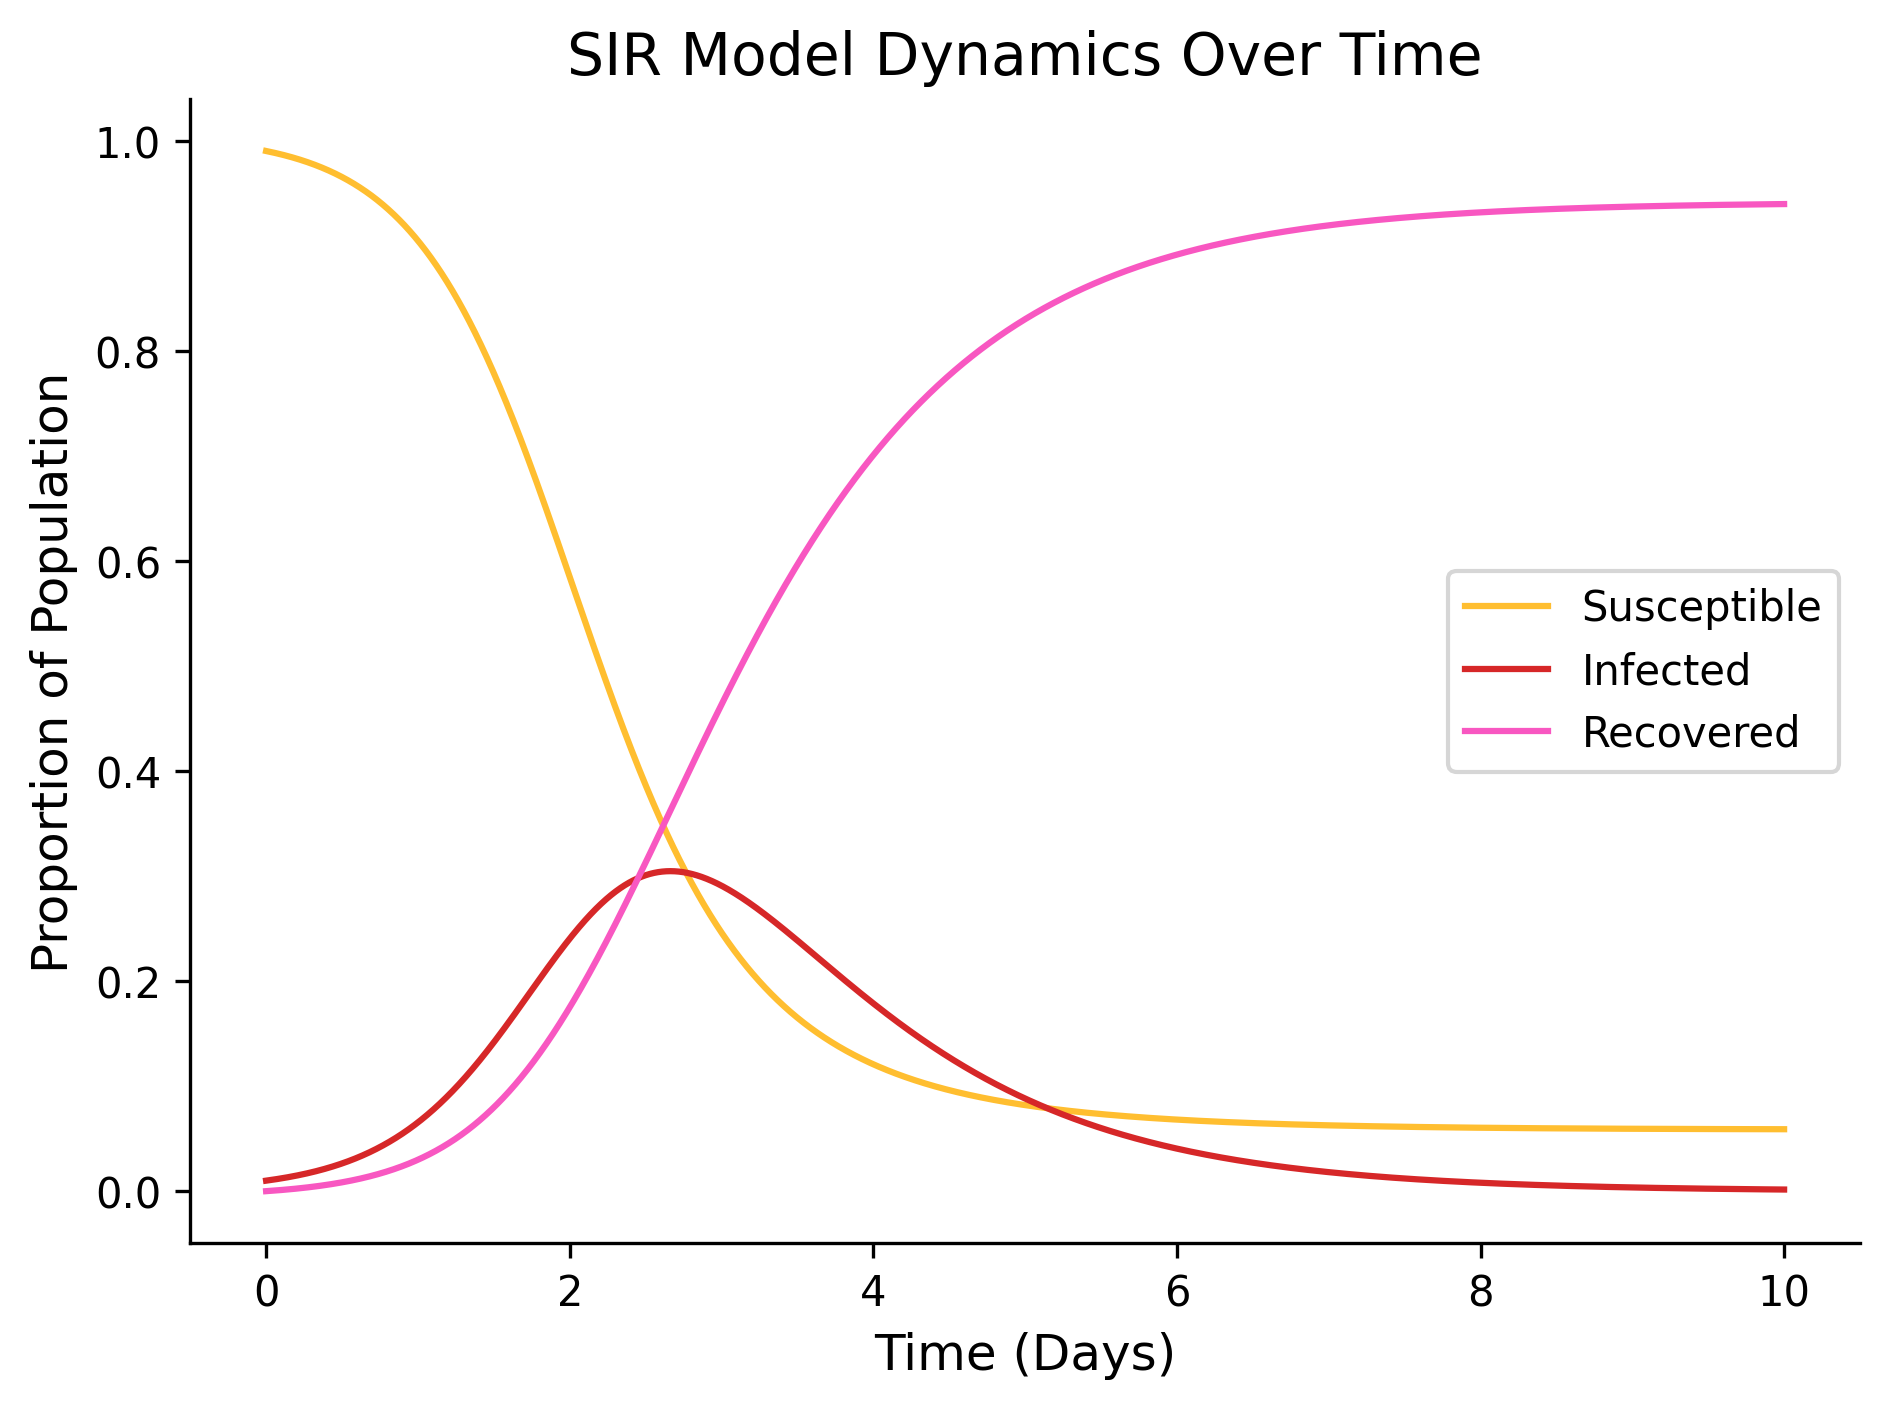

Model works as expected.


In [105]:
test_model = SIRbase(beta=3, gamma=1, I0=0.01)
time, S_proportion, I_proportion, R_proportion = test_model.numerical_integration(t=10, dt=0.001)
plot_sir_model(time, S_proportion, I_proportion, R_proportion, colors, save = False)


if (round(S_proportion[np.argmax(I_proportion)], 3) == round(1/3, 3)):
    print("Model works as expected.")

## Epidemic vs Extinction

In order to understand how some infectious agents become extinct or an epidemic, we run several phase plots for different combinations of $\beta$ and $\gamma$. We categorize these infectious agents as causing an epidemic,$R_0 = \frac{\beta}{\gamma} > 1$ or going extinct, $R_0 < 1$. We pick extreme values of $R_0$ by using `min()` and `max()`.

In [106]:
beta_values = np.linspace(0.5, 2, 10)
gamma_values = np.linspace(0.5, 2, 10)

epidemic_combinations = [
    (beta, gamma) for beta in beta_values for gamma in gamma_values if beta / gamma > 1
]

R0_epi = [beta / gamma for beta, gamma in epidemic_combinations]


extinction_combinations = [
    (beta, gamma) for beta in beta_values for gamma in gamma_values if beta / gamma < 1
]

R0_ex  = [beta / gamma for beta, gamma in extinction_combinations]


# Find the indices of the min and max R_0 values
min_index_epi = R0_epi.index(min(R0_epi))
max_index_epi = R0_epi.index(max(R0_epi))

# Retrieve the corresponding (beta, gamma) pairs
plot_epi = [epidemic_combinations[min_index_epi], epidemic_combinations[max_index_epi]]


# Find the indices of the min and max R_0 values
min_index_ex = R0_ex.index(min(R0_ex))
max_index_ex = R0_ex.index(max(R0_ex))

# Retrieve the corresponding (beta, gamma) pairs
plot_ex = [extinction_combinations[min_index_ex], extinction_combinations[max_index_ex]]


print(plot_epi)
print(plot_ex)

[(2.0, 1.8333333333333333), (2.0, 0.5)]
[(0.5, 2.0), (1.8333333333333333, 2.0)]


We create a model agnostic plotting function for the phase diagrams we use throughout the report. The function specifically has a `subplot_index` parameter for the 2 by 2 plot provided in the report.

In [107]:
def phase_diagram(
    SIR,
    beta,
    gamma,
    I0_values,
    t=300,
    dt=0.01,
    title=None,
    subplot_index=None,
    **kwargs,
):
    """Plots one (or many) Phase Diagrams for same values of the SIR parameters.

    Args:
        SIR (_type_): Any SIR model that is similarly defined as baseSIR()
        beta (_type_): Transmission parameter
        gamma (_type_): Recovery parameter
        I0_values (_type_): An array of I(0) values
        t (int, optional): Length of time for which the SIR model is integrated. Defaults to 300.
        dt (float, optional): Step size for RK4. Defaults to 0.01.
        title (_type_, optional): Title of the Phase Diagram Plot. Defaults to None.
        subplot_index (_type_, optional): For subplots. Defaults to None.
    """    
    if subplot_index is not None:
        plt.subplot(2, 2, subplot_index)  # 2 rows, 2 columns

    plt.plot([1, 0], [0, 1], "r-", linewidth=1, alpha=0.7, label="Diagonal")

    for I0 in I0_values:
        model_instance = SIR(beta=beta, gamma=gamma, I0=I0, **kwargs)
        time, S, I, R = model_instance.numerical_integration(t=t, dt=dt)
        plt.plot(S, I, color=colors["Susceptible"], linewidth=1.5, alpha=0.7)

    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel("Susceptible (S)")
    plt.ylabel("Infected (I)")
    plt.title(title, fontsize=12)
    # Remove the top and right border (spines)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.grid(False)     
    
    plt.gca().set_facecolor("whitesmoke")
    plt.savefig("phasediagram.png", dpi=300)


We run the plotting function four times to create the following plots:
* Two plots that each demonstrate a combination of $\beta$ and $\gamma$ going extinct. We do this for different starting points of $I(0)$
* Two plots that each demonstrate a combination of $\beta$ and $\gamma$ becoming an epidemic. We do this for different starting points of $I(0)$

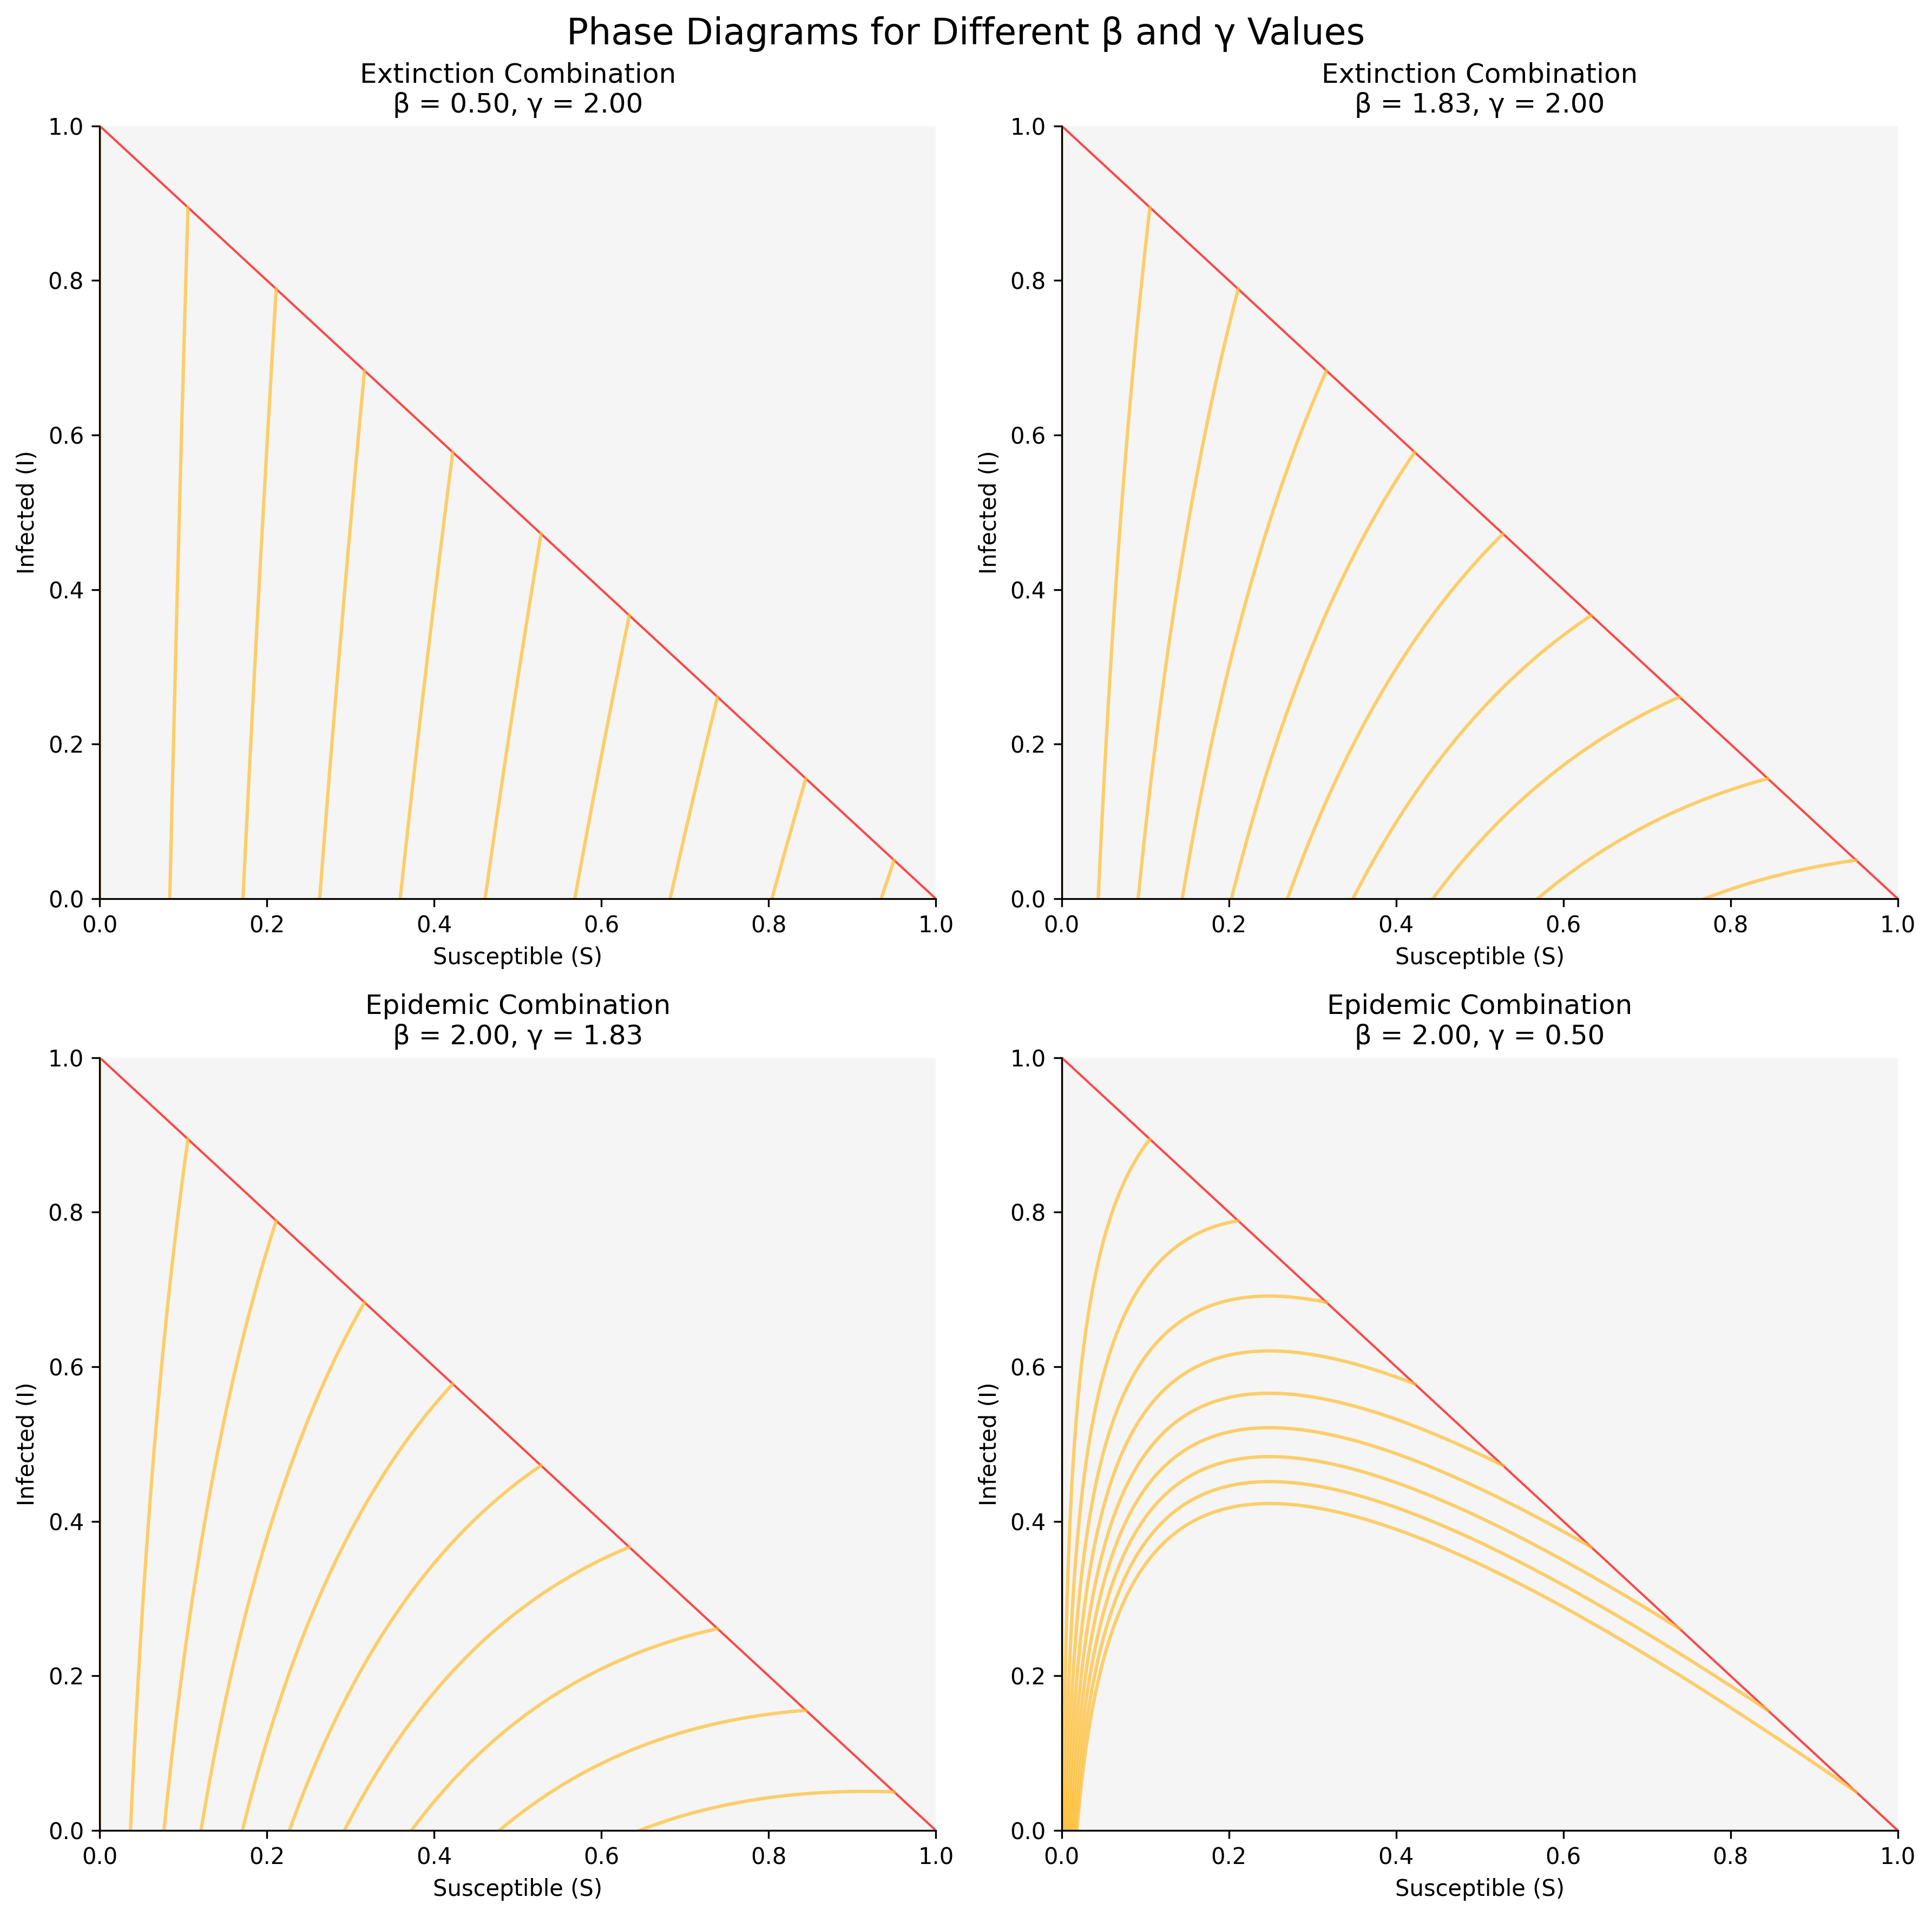

In [108]:
I0_values = np.linspace(0.05, 1, 10)

plt.figure(figsize=(12, 12), dpi = 300)
for i, (beta, gamma) in enumerate(plot_ex):
    phase_diagram(
        SIRbase,
        beta,
        gamma,
        I0_values,
        t=300,
        dt=0.01,
        title=f"Extinction Combination\nβ = {beta:.2f}, γ = {gamma:.2f}",
        subplot_index=i + 1,
    )

for i, (beta, gamma) in enumerate(plot_epi):
    phase_diagram(
        SIRbase,
        beta,
        gamma,
        I0_values,
        t=300,
        dt=0.01,
        title=f"Epidemic Combination\nβ = {beta:.2f}, γ = {gamma:.2f}",
        subplot_index=i + 3,
    )


plt.suptitle("Phase Diagrams for Different β and γ Values", fontsize=16)
plt.subplots_adjust(top=0.9, hspace=0.4, wspace=0.3)
plt.tight_layout()
plt.savefig("extinctionvsepi.png")
plt.show()

## Model Fitting
To fit the `SIRbase()` model to the school Influenza case, a custom Solver class is created that:
1. Computes the gradient, $\nabla$ with respect to any loss function for $(S, I)$ and an array of observed Infectand proportions, $[I_0, I_1, ..., I_t]$,  using the forward differences method.
2. Performs AdaGrad as described by Cormen et al. (2009) [3], which is a variant of gradient descent with an adaptive learning rate for each parameter. For the `SIRbase()` class, these parameters are $\beta$ and $\gamma$
3. Return parameters associated with the lowest loss

We use the mean-squared error as a loss function for `solverSIR`, which is defined as and implemented in code below

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 \ 
$$  

In [109]:
def MSE(estimated_data, observed_data):
    return np.mean((observed_data - estimated_data) ** 2)

class solverSIR:
    def __init__(self, SIR, loss_fn, init_params, **kwargs):
        """Solves the SIR model parameter for an observed infectand population

        Args:
            SIR (_type_): Any SIR model that is simiarily defined as SIRbase()
            loss_fn (_type_): A loss function.
            init_params (_type_): Initial guesses for the model parameters
        """        
        self.classSIR = SIR
        self.loss_fn = loss_fn
        self.params = np.array(init_params)
        self.kwargs = kwargs

    def computeLoss(self, params, obsS):
        """Compute loss value associated with model with parameters

        Args:
            params (_type_): Current state of model parameters
            obsS (_type_): Observed infectand array
        Returns:
            loss_t: The loss associated with the model and the observed infectand array
        """        
        time = len(obsS)

        time_integration, S, I, R = self.classSIR(*params, **self.kwargs).numerical_integration(time - 1, 0.01)

        fitS_t = I[np.isin(time_integration, np.arange(0, time + 1))]

        loss_t = self.loss_fn(obsS, fitS_t)

        return loss_t

    def computeGrad(self, obsS, params, epsilon=1e-8):
        """Computes the gradient

        Args:
            obsS (_type_): Observed infectand array
            params (_type_): Current state of model parameters
            epsilon (_type_, optional): Step size for the model parameter. Defaults to 1e-8.

        Returns:
            grad: Returns gradient
        """        
        grad = np.zeros_like(params)

        loss_t = self.computeLoss(params, obsS)

        for i, _ in enumerate(params):
            params[i] += epsilon

            loss_dt = self.computeLoss(params, obsS)

            grad[i] = (loss_dt - loss_t) / epsilon

            params[i] -= epsilon  # Restore the original parameter

        return grad

    def optimize(self, obsS, learning_rate=0.01, max_iterations=1000, epsilon=1e-8):
        """Performs AdaGrad to find optimal model parameters with lowest loss

        Args:
            obsS (_type_): Observed infectand array
            learning_rate (float, optional): The learning rate used by AdaGrad. Defaults to 0.01.
            max_iterations (int, optional): Maximum number of iterations before AdaGrad terminates. Defaults to 1000.
            epsilon (_type_, optional): Step size for the model parameter. Defaults to 1e-8.

        Returns:
            _type_: The best parameters with the lowest loss
        """        
        params = np.array(self.params, dtype=float)

        lowest_loss = float("inf")
        best_params = params.copy()

    
        accumulated_grad_squares = np.zeros_like(params)

        for iteration in range(max_iterations):
            grad = self.computeGrad(obsS, params)

            params -= learning_rate * grad

            accumulated_grad_squares += grad**2

            adjusted_grad = grad / (np.sqrt(accumulated_grad_squares) + epsilon)
            params -= learning_rate * adjusted_grad

            current_loss = self.computeLoss(params, obsS)

            prev_loss = current_loss

            if current_loss < lowest_loss:
                lowest_loss = current_loss
                best_params = params.copy()

            if iteration % 100 == 0:
                print(
                    f"Iteration {iteration}: Lowest Loss = {lowest_loss}, Best Parameters = {best_params}"
                )

        self.params = best_params
        return best_params, lowest_loss

We perform the above described procedure below. We choose the following parameters for solverSIR:
* Learning rate is set to 0.025
* Maximum iterations is set to 1000
* Initial state for $\beta$ and $\gamma$ is set to (1,1)
* For the numerical integration of the underlying models, we choose a smaller value than the default for higher resolution and less error.

In [110]:
school_data = (
    np.array([1, 3, 8, 28, 75, 221, 291, 255, 235, 190, 125, 70, 28, 12, 5]) / 763
)

solver = solverSIR(SIRbase, MSE, [1, 1], I0=school_data[0])
best_params, loss_value = solver.optimize(
    school_data, learning_rate=0.05, max_iterations=1000
)


Iteration 0: Lowest Loss = 0.035706012447760976, Best Parameters = [1.05011754 0.94988111]
Iteration 100: Lowest Loss = 0.0004595361046631941, Best Parameters = [1.66139851 0.45092024]
Iteration 200: Lowest Loss = 0.0004584493921307215, Best Parameters = [1.66543074 0.45230005]
Iteration 300: Lowest Loss = 0.0004584489398356009, Best Parameters = [1.66551306 0.45232849]
Iteration 400: Lowest Loss = 0.00045844893964224446, Best Parameters = [1.66551475 0.45232907]
Iteration 500: Lowest Loss = 0.00045844893964211566, Best Parameters = [1.66551479 0.45232909]
Iteration 600: Lowest Loss = 0.00045844893964211366, Best Parameters = [1.66551479 0.45232909]
Iteration 700: Lowest Loss = 0.00045844893964211344, Best Parameters = [1.66551479 0.45232909]
Iteration 800: Lowest Loss = 0.00045844893964211344, Best Parameters = [1.66551479 0.45232909]
Iteration 900: Lowest Loss = 0.00045844893964211317, Best Parameters = [1.66551479 0.45232909]


We run `SIRbase` with optimial parameters and plot the results against the School Influenza data.

<Figure size 1000x600 with 0 Axes>

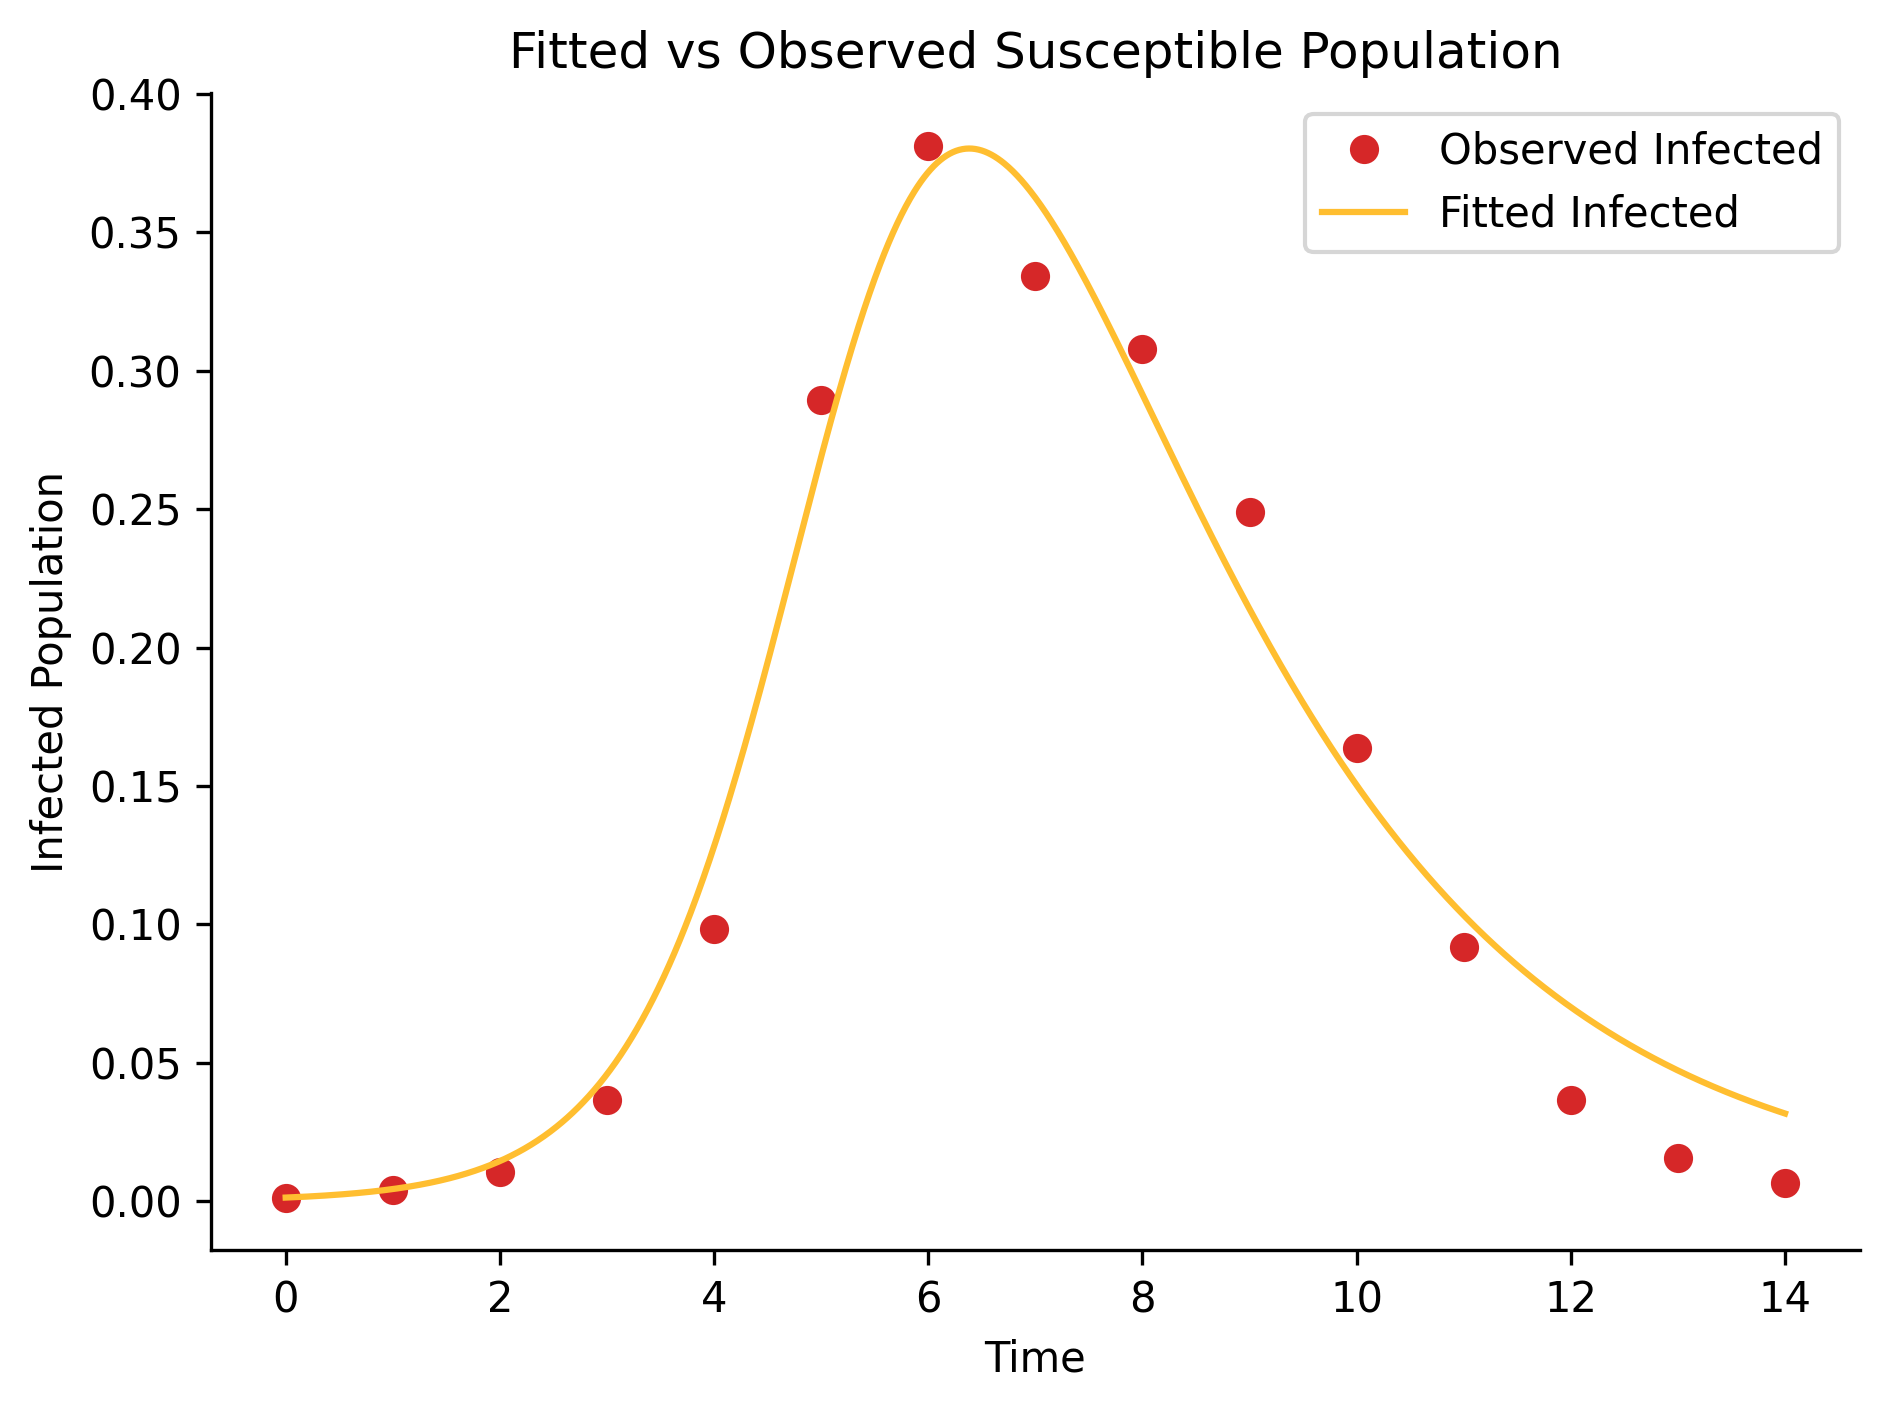

Beta: 1.6655147888916946, Gamma 0.4523290864786533, R0 = 3.6820864248584977 


In [111]:
time_school = len(school_data)

best_model = SIRbase(*best_params, school_data[0])
t, S, I, R = best_model.numerical_integration(time_school-1)

plt.figure(figsize=(10, 6))
plt.figure(dpi=300)
plt.plot(np.arange(0, time_school), school_data, "o", label="Observed Infected", color = colors["Infected"])
plt.plot(t, I, "-", label="Fitted Infected", color = colors["Susceptible"])
plt.xlabel("Time")
plt.ylabel("Infected Population")
plt.title("Fitted vs Observed Susceptible Population")

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.grid(False)


plt.tight_layout()
plt.legend()
plt.savefig("school_fit.png")
plt.show()
print(f"Beta: {best_params[0]}, Gamma {best_params[1]}, R0 = {best_params[0]/best_params[1]} ")

## Vaccination Programs

We introduce two vaccination strategies for the school Influenza outbreak. 

### Zero-Day
Firstly, we consider Day-Zero vaccination as a viable strategy. From the get-go, pupils are vaccinated at a flat vaccination rate $\alpha$. We create a new class, `SIRflatvax`, which inherits from `SIRbase`. We run the model for different values of $\alpha$ and plot the reduction in the infection peak. We choose values between $0$ and $0.1$.

In [112]:
class SIRflatvax(SIRbase):
    def __init__(self, beta: float, gamma: float, I0: float, vaccination_rate: float):
        """
        Initialize SIR model with vaccination parameters
        """
        super().__init__(beta, gamma, I0)
        self.vaccination_rate = vaccination_rate

    def dSdt(self, S, I) -> float:
        """
        Differential equation for susceptible population.
        """
        return -self.beta * S * I - self.vaccination_rate * S
    

    def dRdt(self, I, S) -> float:
        """
        Differential equation for recovered population.
        """
        return self.gamma * I + self.vaccination_rate * S

In [113]:
T,S,I,R = SIRflatvax(*best_params, school_data[0], 0.0).numerical_integration(time_school)
max(I) * 763

290.19470274947827

### Dynamic Intervention

A second vaccination strategy we consider is dynamic intervention. The `SIRftcvax` class extends the base `SIRbase` model by introducing dynamic vaccination rates. The strength of the intervention, given by `control_factor`, is based on a couple of factors:
* How high the maximum vaccination rate is, $\alpha_{\text{max}}$
* The carrying capacity of the population, `capacity`, which is defined as the proportion of infectands. If the currect infection rate is equal or above the carrying rate, we want to vaccinate at $\alpha_{\text{max}}$.


In [114]:
class SIRftcvax(SIRbase):
    def __init__(self, beta: float, gamma: float, I0: float, vaccination_max: float, capacity: float, steepness: float):
        """
        Initialize SIR model with dynamic vaccination rate and a phi parameter.

        Parameters:
        - beta: Infection rate
        - gamma: Recovery rate
        - I0: Initial infected population
        - vaccination_max: Maximum possible vaccination rate
        - capacity: Maximum infection level before strong intervention
        - steepness: How rapidly intervention increases around capacity
        - phi: Parameter that modulates vaccination rate (0 <= phi <= 1)
        """
        super().__init__(beta, gamma, I0)
        self.vaccination_max = vaccination_max
        self.capacity = capacity
        self.steepness = steepness

    def control_factor(self, I: float) -> float:
        """
        Calculate intervention strength based on infection level (I).
        This will smoothly increase as infections approach capacity.
        """
        return 1 / (1 + np.exp(-self.steepness * (I - self.capacity)))

    def vaccination_rate(self, I: float) -> float:
        """
        Calculate the vaccination rate, modulated by phi and infection levels relative to capacity.
        """
        return self.vaccination_max * self.control_factor(I)

    def dSdt(self, S: float, I: float) -> float:
        """
        Differential equation for the susceptible population, including infection dynamics and vaccination.
        """
        return -self.beta * S * I - self.vaccination_rate(I) * S

    def numerical_integration(self, t: int, dt: float = 0.01):
        """
        Perform numerical integration over time using Euler's method.
        
        Returns time series data for S, I, R, vaccination rates, and control factors.
        """
        times = np.arange(0, t + dt, dt)
        S_values, I_values, R_values = [self.S], [self.I], [self.R]
        vaccination_rates = [self.vaccination_rate(self.I)]
        control_factors = [self.control_factor(self.I)]

        for _ in times[1:]:
            self.update_step(dt)  # Update step via Euler method (or any numerical method)
            S_values.append(self.S)
            I_values.append(self.I)
            R_values.append(self.R)
            vaccination_rates.append(self.vaccination_rate(self.I))
            control_factors.append(self.control_factor(self.I))

        return np.column_stack((times, S_values, I_values, R_values, vaccination_rates, control_factors)).T


We plot these two vaccination programs side-by-side to save space. For the first plot, we run the model as many times as we have vaccination rates. Then, we plot the infection curve of each model with their vaccination rates. For the second plot, we define a grid of values for `capacity` and `max_vaccination_rate`. Because the relationship is poorly visualized in 3D, we use a heatmap to show the peak proportion of infectands for different combinations of both paramaters.

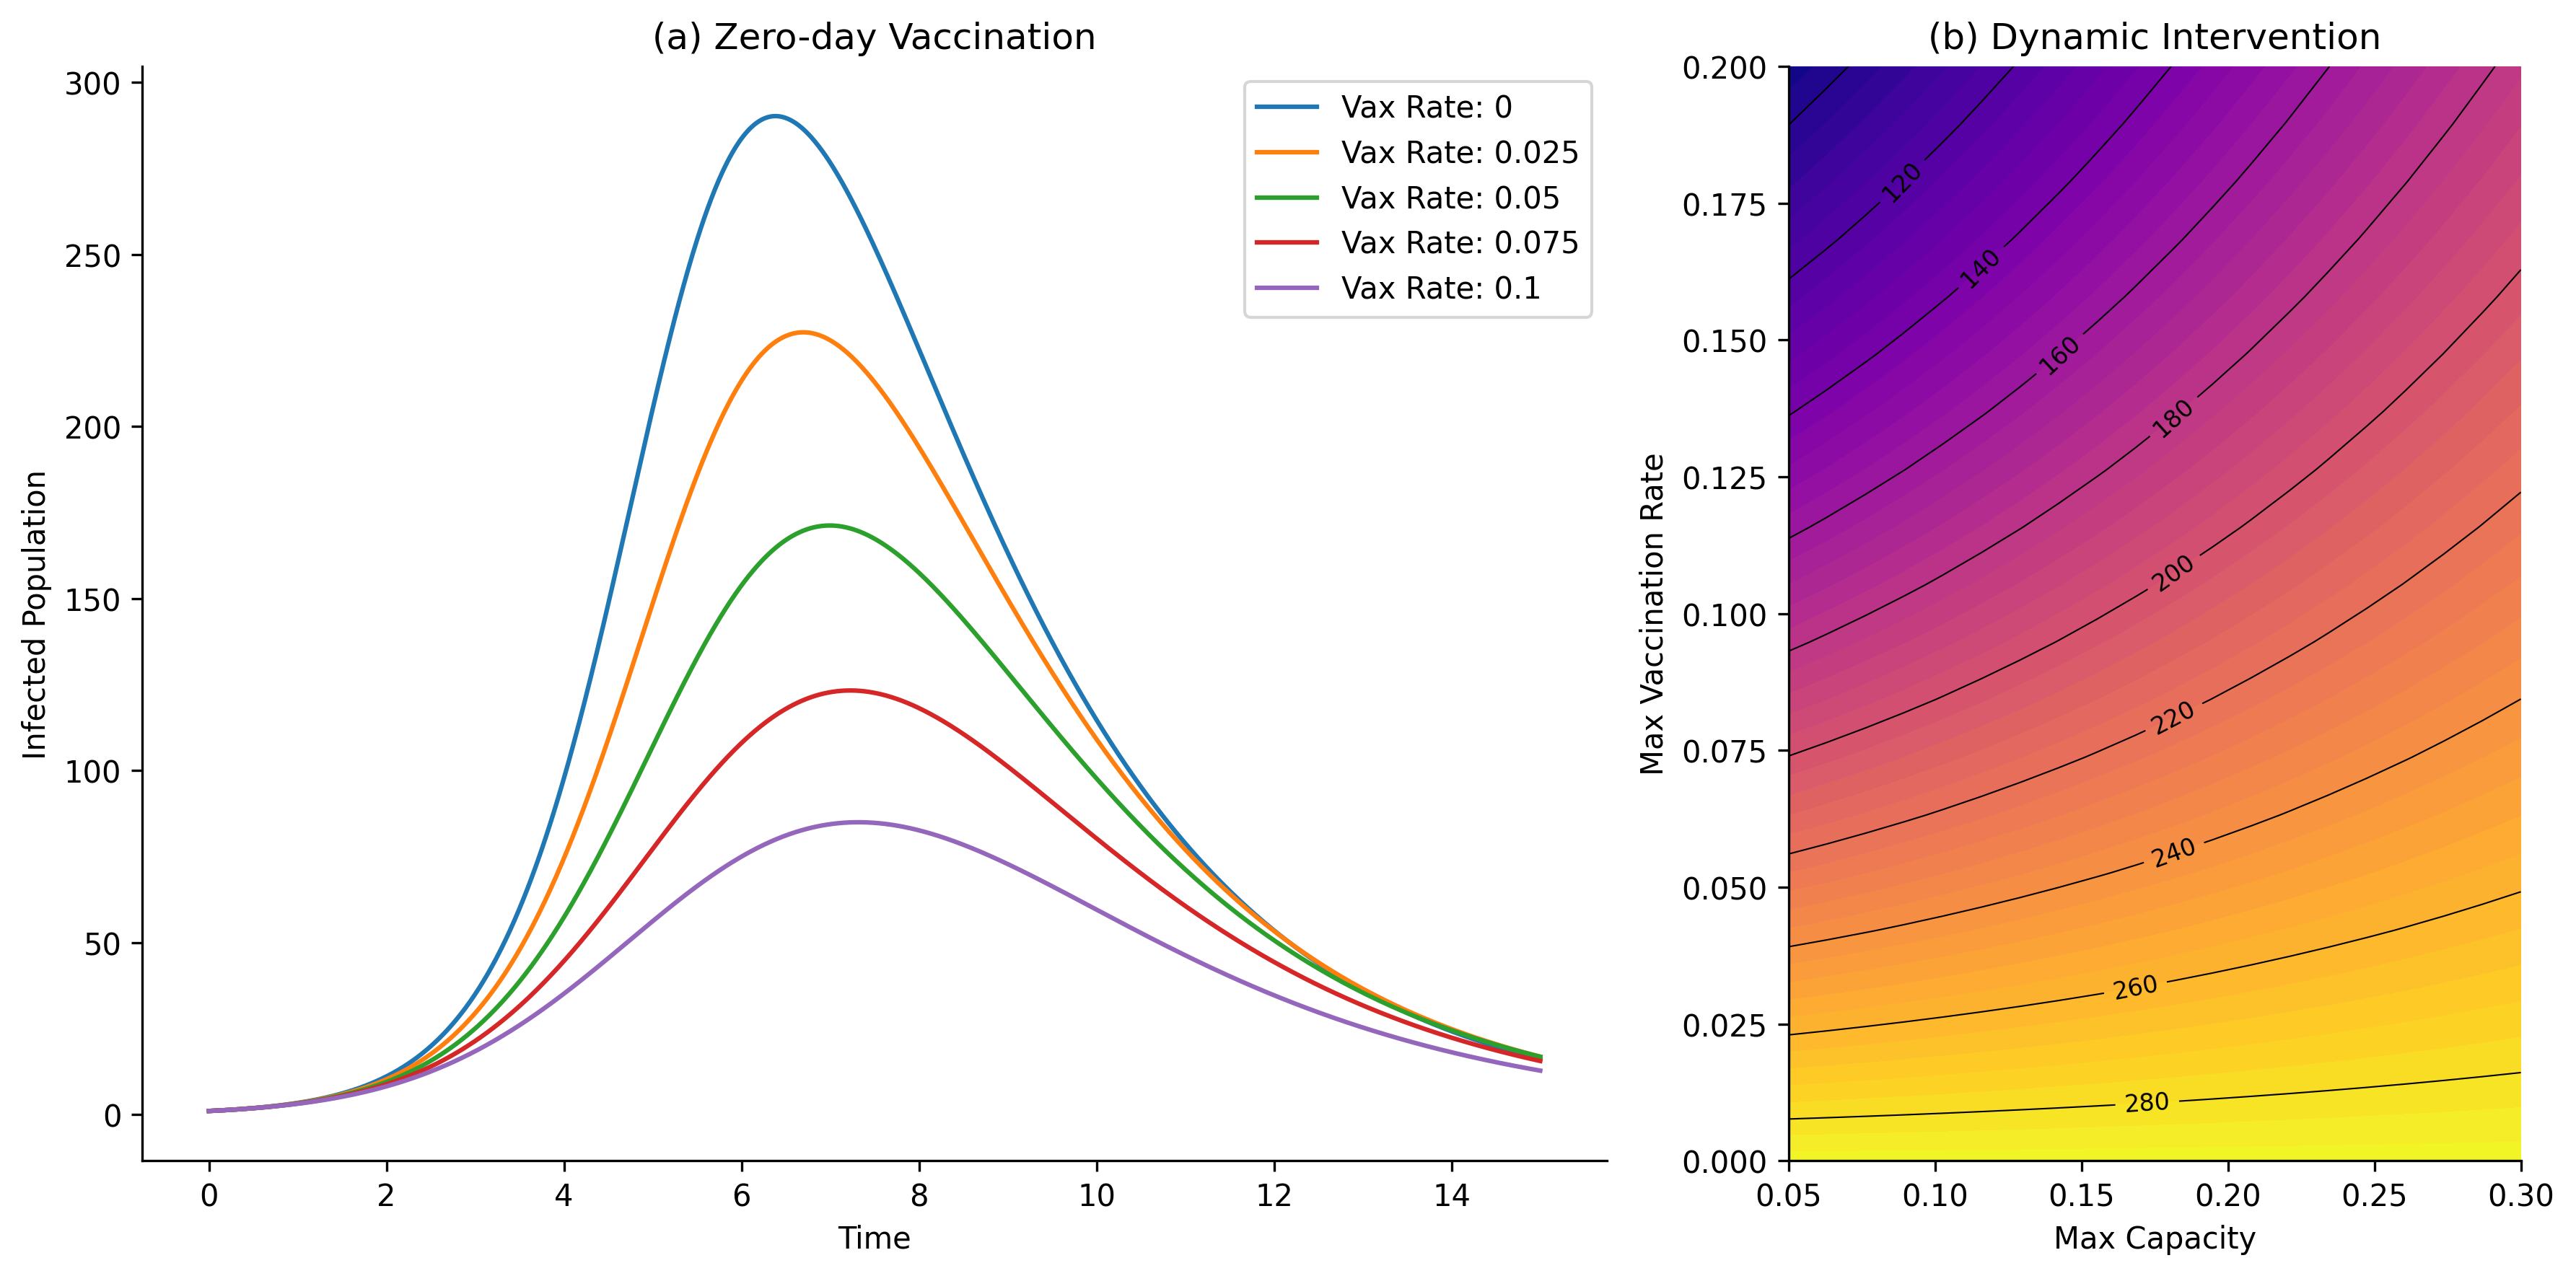

In [115]:
from matplotlib.gridspec import GridSpec

# Define your vaccination rates
vaccination_rates = [0, 0.025, 0.05, 0.075, 0.1]

# Define ranges for capacity and vaccination rate
capacities = np.linspace(0.05, 0.3, 20)  # 20 values for max capacity
vaccination_rate_grid = np.linspace(0.0, 0.20, 20)  # 20 values for max vaccination rate

# Prepare a grid for peak infected
peak_infected = np.zeros((len(capacities), len(vaccination_rate_grid)))

# Create a figure and use GridSpec to control the plot size ratios
fig = plt.figure(figsize=(12, 6), dpi=300)
gs = GridSpec(1, 2, width_ratios=[2, 1], figure=fig)  # Set width ratio to make second plot smaller

# Subplot 1: Line plot for infection peak reduction
ax1 = fig.add_subplot(gs[0])
for vax_rate in vaccination_rates:
    # Assuming `SIRflatvax` and `best_params`, `school_data`, and `time_school` are predefined in your context
    model = SIRflatvax(*best_params, school_data[0], vax_rate)
    t, S, I, R = model.numerical_integration(t=time_school)
    ax1.plot(t, I*763, label=f'Vax Rate: {vax_rate}')

ax1.set_title('(a) Zero-day Vaccination', fontsize=12)
ax1.set_xlabel('Time')
ax1.set_ylabel('Infected Population')
ax1.legend()


def run_model_and_get_peak(beta, gamma, I0, vaccination_max, capacity, steepness, t):
    model = SIRftcvax(beta, gamma, I0, vaccination_max, capacity, steepness)
    results = model.numerical_integration(t)
    I_values = results[2]  # Extract infected values
    return np.max(I_values)  # Return peak number of infected


# Define ranges for capacity and vaccination rate
capacities = np.linspace(0.05, 0.3, 20)  # 20 values from 0.1 to 2.0
vaccination_rates = np.linspace(0.0, 0.20, 20)  # 20 values from 0 to 1

# Prepare a grid for peak infecteds
peak_infected = np.zeros((len(capacities), len(vaccination_rates)))

# Run simulations over the grid
for i, capacity in enumerate(capacities):
    for j, vaccination_max in enumerate(vaccination_rates):
        peak_infected[i, j] = run_model_and_get_peak(*best_params, I0 = school_data[0], vaccination_max = vaccination_max, capacity = capacity, steepness = 5, t=time_school) * 763

# Create 3D plot
capacity_grid, vaccination_grid = np.meshgrid(capacities, vaccination_rates)


# Subplot 2: Heatmap of peak infected as a function of capacity and vaccination rate
ax2 = fig.add_subplot(gs[1])
c = ax2.contourf(capacities, vaccination_rate_grid, peak_infected.T, levels=50, cmap='plasma')
contours = ax2.contour(capacities, vaccination_rate_grid, peak_infected.T, levels=10, colors='black', linewidths=0.5)
ax2.clabel(contours, inline=True, fontsize=8)

ax2.set_xlabel('Max Capacity')
ax2.set_ylabel('Max Vaccination Rate')
ax2.set_title('(b) Dynamic Intervention', fontsize=12)

# Remove unnecessary spines from both subplots
for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Adjust layout for better spacing
plt.tight_layout()

# Save the figure with high resolution (300 DPI)
plt.savefig('combined_plot_with_labels.png', dpi=300)
plt.show()



## SIR with Demography

We introduce a new variant of SIR, `SIRdemography`, that adds a natural birth and death rate. For now, we assume a constant population, so these two rates are equal to each other and simply implemented as a single parameter, `birth_rate`. According to Keeling et al. (2008) [2], the system of ordinary differential equations for the SIR with demography is defined as 
$$
\frac{dS}{dt} = \mu -\beta S I - \mu S \\
\frac{dI}{dt} = \beta S I - \gamma I - \mu I \\
\frac{dR}{dt} = \gamma I - \mu R
$$
We do not implement $\frac{dR}{dT}$ as a constant population size is assumed. The `SIRdemography` class inherits from `SIRbase`.

In [116]:
class SIRdemography(SIRbase):
    def __init__(self, beta: float, gamma: float, I0: float, mu: float):
        """
        Initialize SIR model with demography parameters
        """
        super().__init__(beta, gamma, I0)
        self.mu = mu

    def dSdt(self, S, I):
        """
        Differential equation for susceptible population including demography.
        """
        return self.mu - self.beta * S * I - self.mu * S

    def dIdt(self, S, I):
        """
        Differential equation for infected population including demography.
        """
        return self.beta * S * I - I * self.gamma - I*self.mu
    
    def dRdt(self, I, R):
        return self.gamma * I - self.mu * R

    def update_step(self, dt=0.01):
        """
        Perform step update using the Runge–Kutta method, including infection-induced mortality.
        """

        delta_S = RK4(self.dSdt, (self.S, self.I), step_size=dt)
        delta_I = RK4(self.dIdt, (self.S, self.I), step_size=dt)
        delta_R = RK4(self.dRdt, (self.I, self.R), step_size=dt)
        
        self.S += delta_S
        self.I += delta_I
        self.R += delta_R

In order to investigate the newly introduced dynamics by this additional parameter, we perform an Eigenvalue analysis as documented by Keeling et al. (2008) [2]. There are a handful steps we perform in the eigenvalue analysis that are reflected in the function implented in code below:
1. We compute the equilibria for an endemic infectious disease, given below
$$
(S^*, I^*) = (\frac{\gamma + \mu}{\beta}, \frac{\mu}{\beta}(R_0-1))
$$
2. Create the Jacobian matrix, $J$, and find the eigenvalues of this system using $\det  (J-\lambda I) = 0$


$$
\det\left(\begin{pmatrix}
-\beta I^* - \mu - \lambda & -\beta S^*  \\
\beta I^* & \beta S^* - (\gamma + \mu) - \lambda
\end{pmatrix}\right) = 0
$$

3. Check whether the equilibria is stable: Are all real eigenvalues negative?
4. See if the equilibria is approached by damped oscillations. If they are, compute the decay rate (D) and the period of oscillations (T), as
$$
T\sim2\pi\sqrt{AG}, D = - \frac{\mu R_0}{2} \\
\text{where } A = \frac{1}{\mu(R_0-1)},  G = \frac{1}{\mu + \gamma}
$$


In [117]:
def compute_period_oscillations(beta, gamma, mu):
    """
    Compute the period of oscillations for the endemic equilibrium.

    Parameters:
    - beta: Infection rate
    - gamma: Recovery rate
    - mu: Birth/death rate

    Returns:
    - The period of oscillations.
    """
    reproductive_number = beta / (gamma + mu)
    
    # Compute parameters for oscillation period formula
    A = 1 / (mu * (reproductive_number - 1))
    G = 1 / (mu + gamma)
    
    # Return the oscillation period
    return 1 / (2 * math.pi * np.sqrt(A * G))


def decay_rate(beta, gamma, mu):
    """
    Compute the decay rate of oscillations in the system.

    Parameters:
    - beta: Infection rate
    - gamma: Recovery rate
    - mu: Birth/death rate

    Returns:
    - Decay rate.
    """
    reproductive_number = beta / (gamma + mu)
    
    # Return the decay rate
    return -(mu * reproductive_number / 2)

def eigenvalue_analysis(beta, gamma, mu):
    """
    Perform an eigenvalue analysis to assess the stability of the endemic equilibrium.

    Parameters:
    - beta: Infection rate
    - gamma: Recovery rate
    - mu: Birth/death rate
    
    Raises:
    - ValueError: If the reproductive number (R0) is less than or equal to 1.
    """
    reproductive_number = beta / (gamma + mu)

    # Ensure R0 > 1 for an endemic equilibrium
    if reproductive_number <= 1:
        raise ValueError("R0 must be greater than 1 for an endemic equilibrium.")
    
    # Calculate endemic equilibrium points
    S_equil = (gamma + mu) / beta
    I_equil = (mu / beta) * (reproductive_number - 1)

    # Construct the Jacobian matrix at the endemic equilibrium
    J = np.array([[-beta * I_equil - mu, -beta * S_equil],
                  [beta * I_equil, beta * S_equil - (gamma + mu)]])

    # Compute the eigenvalues of the Jacobian matrix
    eigenvalues, _ = eig(J)
    print(f"Eigenvalues of the Jacobian: {eigenvalues}")
    
    # Check stability based on the real parts of the eigenvalues
    if np.all(np.real(eigenvalues) < 0):
        print("The endemic equilibrium is stable.")
    else:
        print("The endemic equilibrium is not stable.")

    # Check for damped oscillations based on the imaginary parts of the eigenvalues
    if np.any(np.imag(eigenvalues) != 0):
        print(f"The system approaches the endemic equilibrium (S: {S_equil}, I: {I_equil}) with damped oscillations.")
        print(f"The system has an oscillation period of {compute_period_oscillations(beta, gamma, mu)} and decay rate of {decay_rate(beta, gamma, mu)}")
    else:
        print(f"The system approaches the endemic equilibrium (S: {S_equil}, I: {I_equil}) without oscillations.")



We use the above function to determine which values to investigate to find an endemic system and to verify any further calculations we perform. We plug in a handful of numbers that may indicate such a system. Using theory, we know in general diseases are endemic when $R_0 = \frac{\beta}{\gamma + \mu} > 1$. We find $\beta = 1, \gamma = 0.3, \mu = \frac{1}{20}$ as an endemic infectious disease.

Eigenvalues of the Jacobian: [-0.07142857+0.16552329j -0.07142857-0.16552329j]
The endemic equilibrium is stable.
The system approaches the endemic equilibrium (S: 0.35, I: 0.09285714285714286) with damped oscillations.
The system has an oscillation period of 0.028692065403069095 and decay rate of -0.07142857142857144


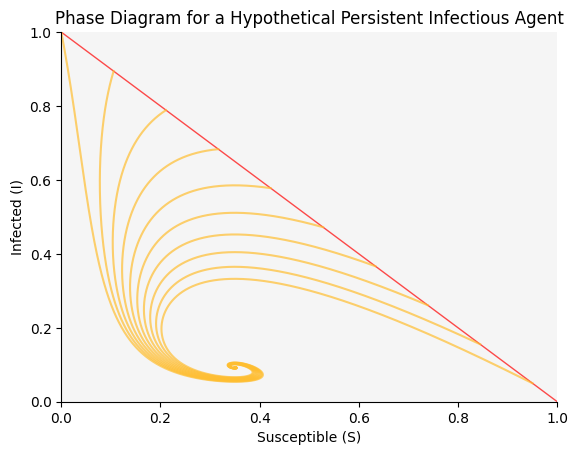

In [118]:
beta = 1
gamma = 0.3
mu =  1/20
eigenvalue_analysis(beta, gamma, mu)

I0_values = np.linspace(0.05, 1, 10)


endemic_t = 200
endemic_dt = 0.005
t, S, I, R = SIRdemography(1, 0.3, 0.01, 1/20).numerical_integration(t = endemic_t, dt = endemic_dt)
phase_diagram(SIRdemography, beta= beta, gamma = gamma, mu = mu, I0_values = I0_values, t= endemic_t, dt= endemic_dt, title="Phase Diagram for a Hypothetical Persistent Infectious Agent")

Indeed, we observe a stable spiral with damped oscillations from our phase plot for this set of parameter values. In addition, we verify this equilibria via the results of our numerical integration.

In [119]:
eigenvalue_analysis(beta, gamma, mu)
np.round([S[-1],I[-1]],6)

Eigenvalues of the Jacobian: [-0.07142857+0.16552329j -0.07142857-0.16552329j]
The endemic equilibrium is stable.
The system approaches the endemic equilibrium (S: 0.35, I: 0.09285714285714286) with damped oscillations.
The system has an oscillation period of 0.028692065403069095 and decay rate of -0.07142857142857144


array([0.35    , 0.092857])

We conduct a Fourier analysis to investigate the nature of the damped oscillations. First, we create a general plot to visually investigate the nature of these oscillations and to get a rough idea of the period and decay rate.

C:\Users\NaniComputationalSci\AppData\Local\Temp\ipykernel_47736\591284766.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(t, S, 'b-', label='Susceptible', color=colors["Susceptible"])
C:\Users\NaniComputationalSci\AppData\Local\Temp\ipykernel_47736\591284766.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(t, I, 'r-', label='Infected', color=colors["Infected"])
C:\Users\NaniComputationalSci\AppData\Local\Temp\ipykernel_47736\591284766.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g-" (-> color='g'). The keyword argument will take precedence.
  plt.plot(t, R, 'g-', label='Recovered', color=colors["Recovered"])


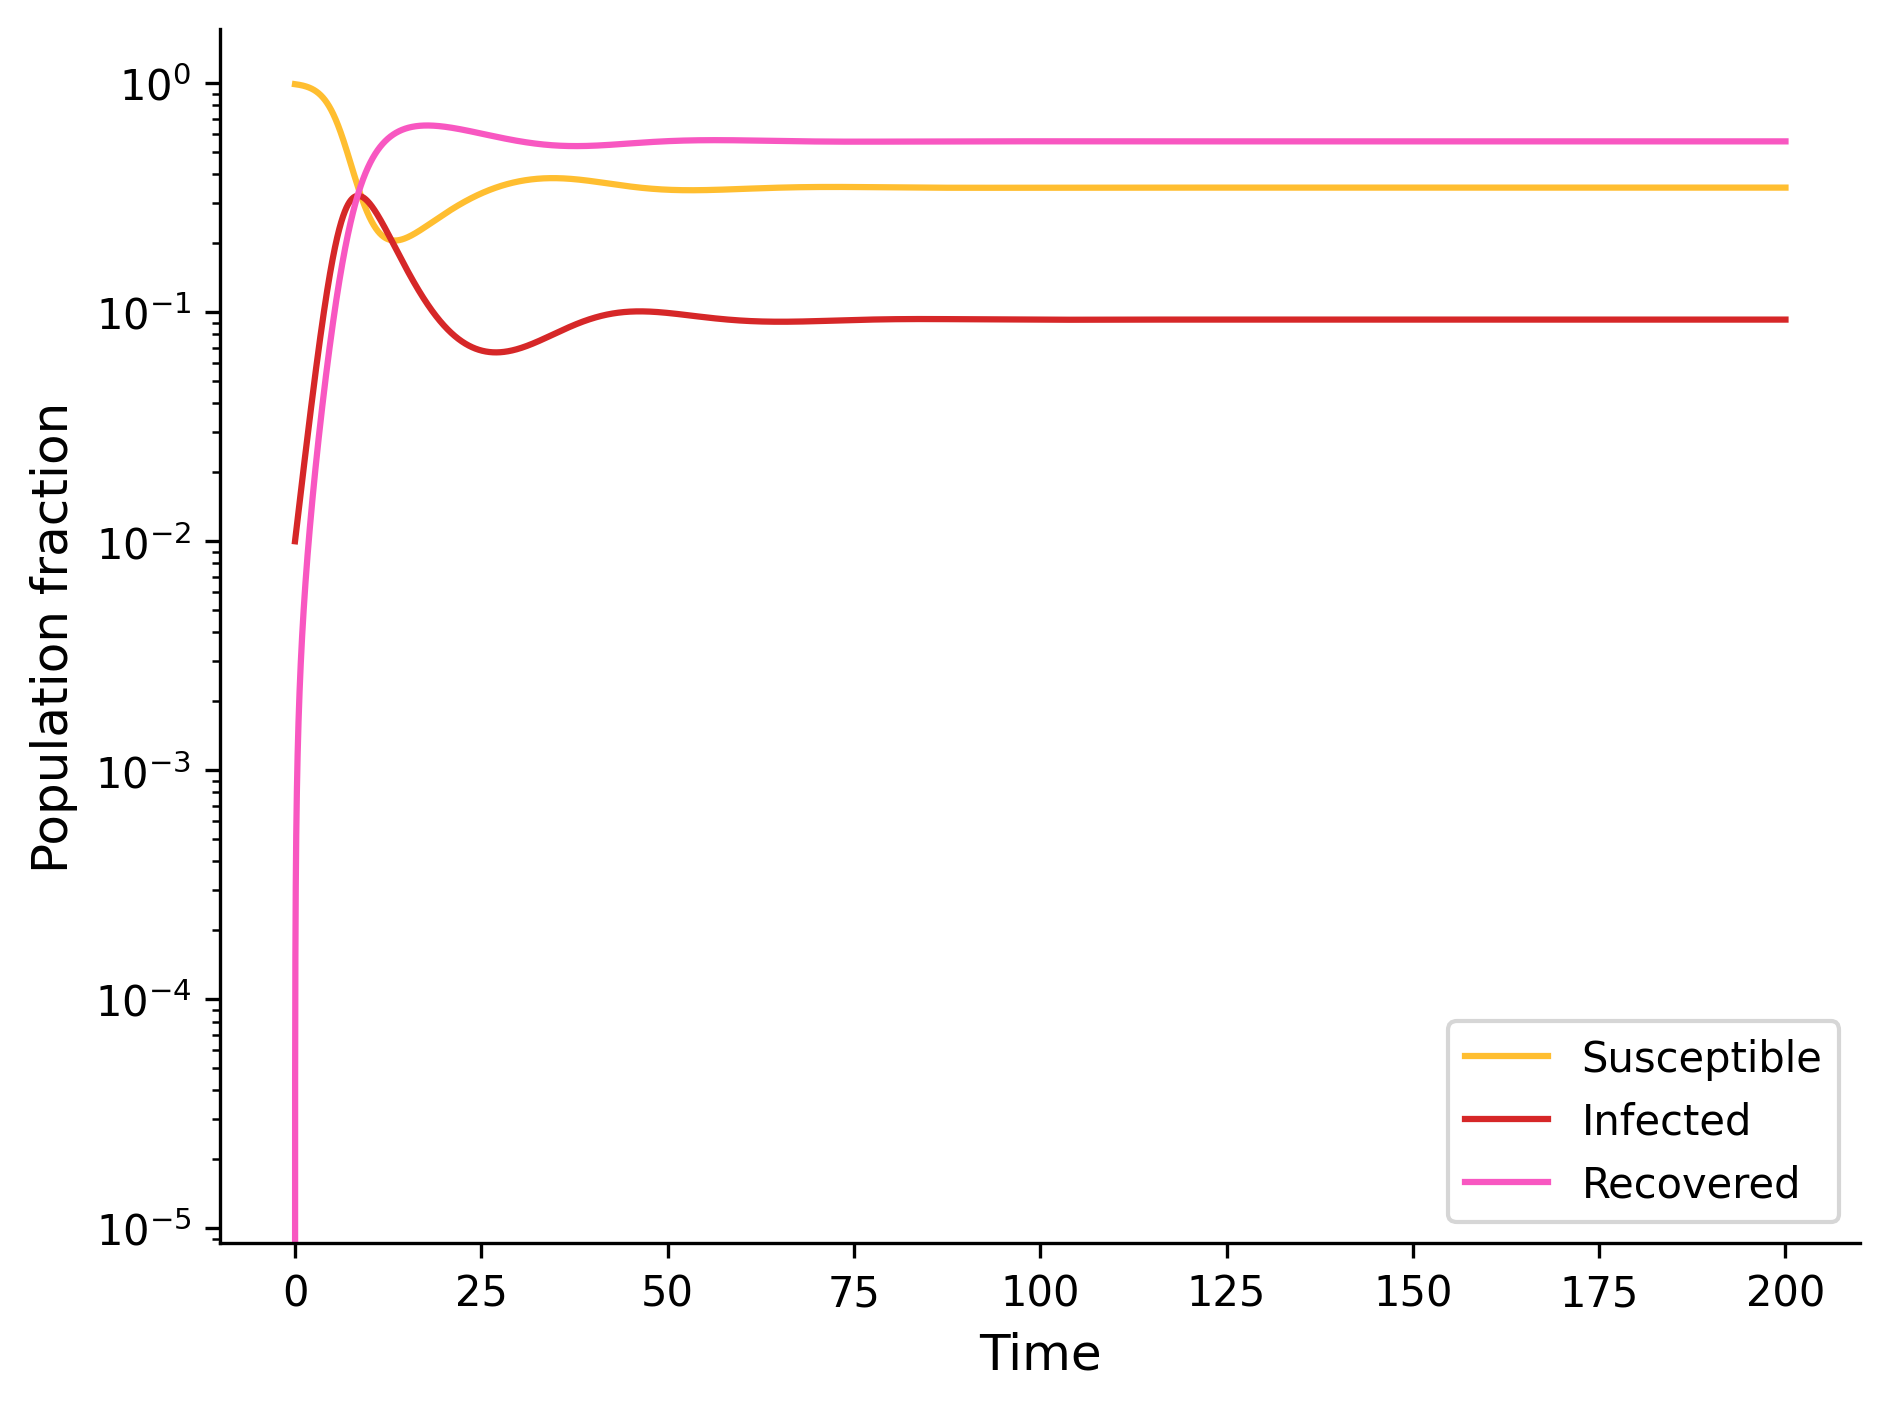

In [120]:
plt.figure(dpi=300)
plt.plot(t, S, 'b-', label='Susceptible', color=colors["Susceptible"])
plt.plot(t, I, 'r-', label='Infected', color=colors["Infected"])
plt.plot(t, R, 'g-', label='Recovered', color=colors["Recovered"])
plt.xlabel('Time', fontsize=12)
plt.ylabel('Population fraction', fontsize=12)
plt.yscale('log')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend()
plt.tight_layout()
plt.show()

We plot the Fourier analysis using the results from the numerical integration of the endemic system. We center the proportion of infectands values to get a clearer plot.  Indeed, we observe a peak at roughly 0.028, which correspond to our eigenvalue analysis.

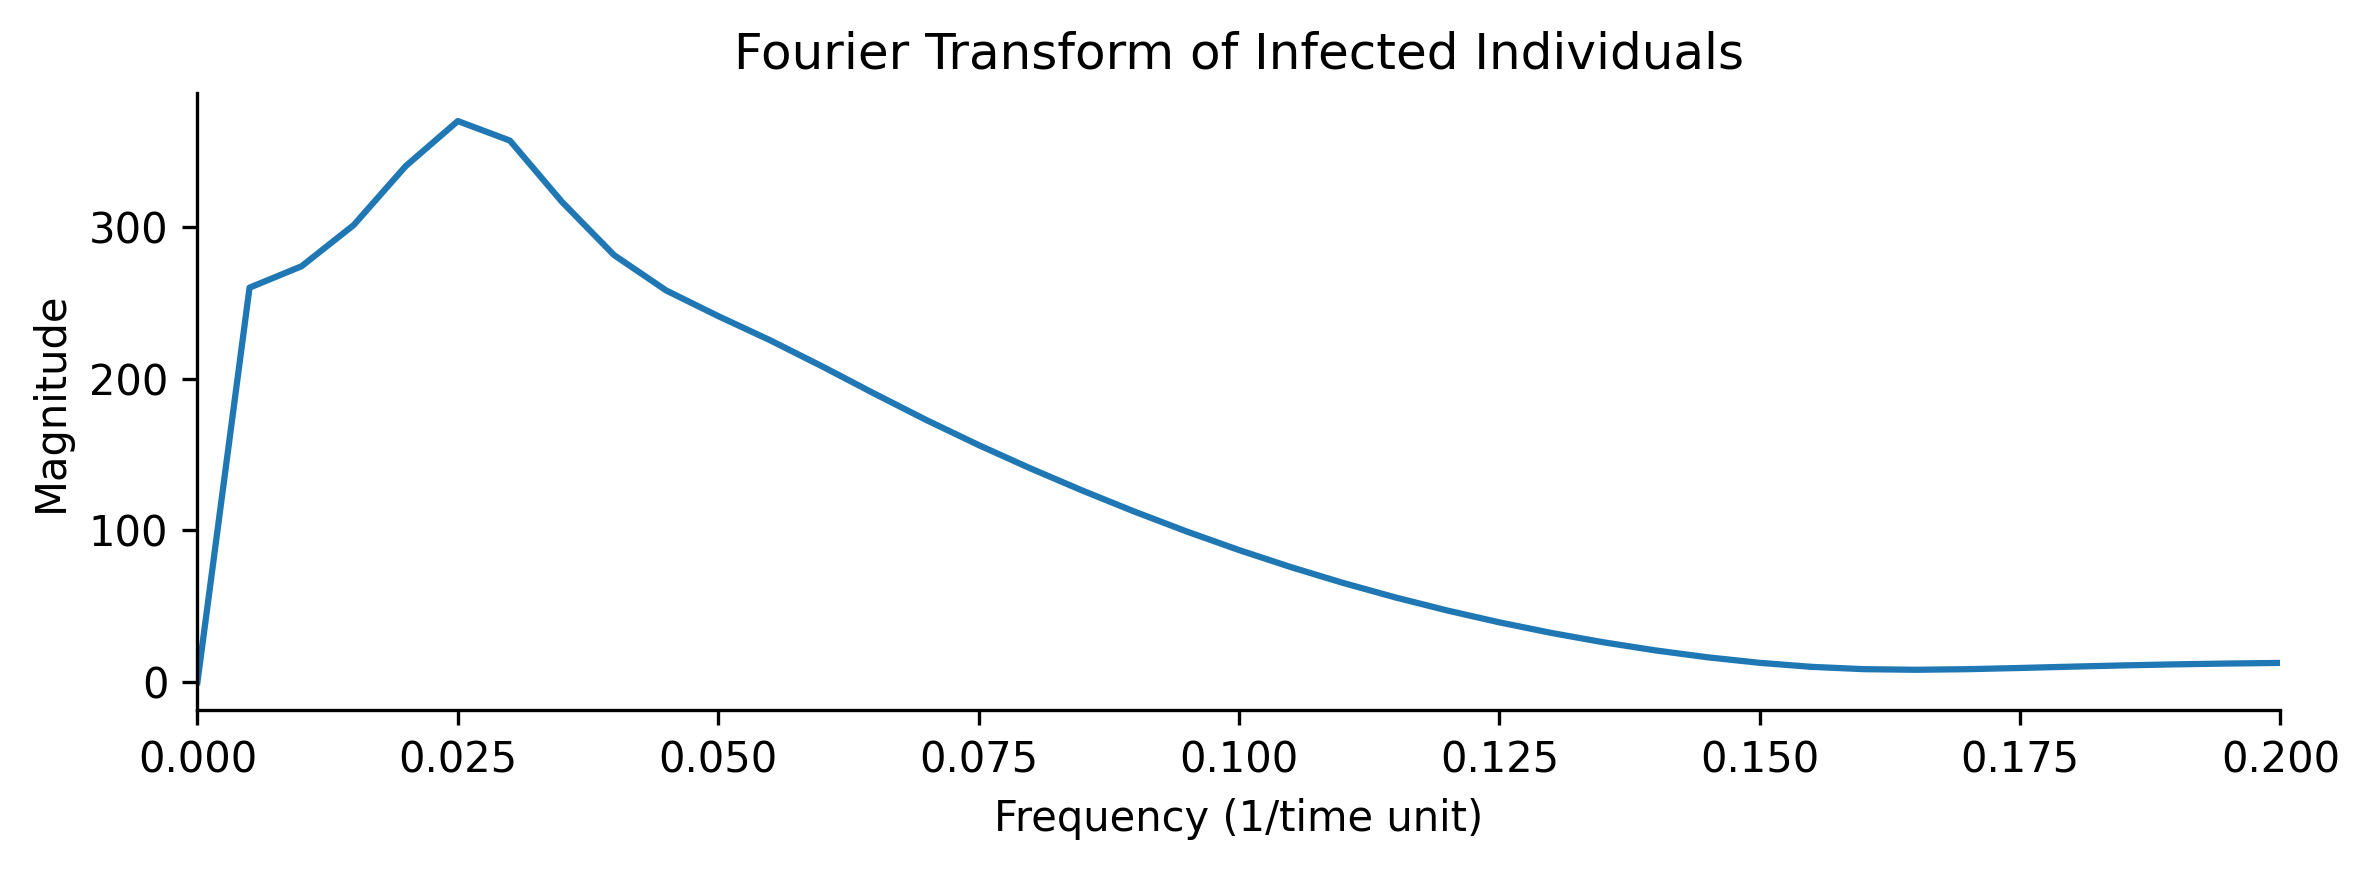

In [121]:
n = len(t)  # Length of the data
fourier = fft.fft(I - np.mean(I))
freqs = fft.fftfreq(n, d=endemic_dt)  # Correctly compute frequencies based on time step

# Consider only positive frequencies
positive_freqs = freqs[freqs >= 0]
abs_fourier = np.abs(fourier[:len(positive_freqs)])  # Only take the positive frequencies

# Plotting
plt.figure(figsize=(8, 3), dpi = 300) 
plt.plot(positive_freqs, abs_fourier)
plt.xlim(0.0, 0.2)  # Adjust the x-axis limit to focus on the range of interest
plt.xlabel('Frequency (1/time unit)')
plt.ylabel('Magnitude')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('Fourier Transform of Infected Individuals')
plt.tight_layout()
plt.savefig("fourier.png", dpi = 300)
plt.show()

## Incorporating Death due to Infection

Until now, all SIR models have primarily assumed constant population size. Now, we will relax this assumption entirely by incorporating the probability of dying due to the infection, $\rho$. 

In [122]:
class SIRmortality(SIRdemography):
    def __init__(
        self,
        beta: float,
        gamma: float,
        I0: float,
        mu: float,
        mortality_probability: float,
    ):
        super().__init__(beta, gamma, I0, mu)
        self.mortality_probability = mortality_probability
        self.S = 1 - I0  # Assume initial S is 1 - I0
        self.I = I0
        self.R = 0
        self.track_population = [self.S+self.I+self.R]

    def dIdt(self, S, I):
        """
        Differential equation for infected population including demography.
        """
        return self.beta * S * I - I*((self.gamma + self.mu)/(1-self.mortality_probability))

    def update_step(self, dt=0.01):
        """
        Perform step update using the Runge–Kutta method, including infection-induced mortality.
        """
        update_S = RK4(self.dSdt, (self.S, self.I), step_size=dt)
        update_I = RK4(self.dIdt, (self.S, self.I), step_size=dt)
        update_R = RK4(self.dRdt, (self.I, self.R), step_size=dt)

        self.S += update_S
        self.I += update_I
        self.R += update_R

    def numerical_integration(self, t: int, dt: float = 0.01):
        """Numerical Integration of the SIR model over time t using RK4 with step size dt.

        Args:
            t (int): Total time.
            dt (float, optional): Step size for RK4. Defaults to 0.01.

        Returns:
            Matrix of t, S, I, R

        """
        times = np.arange(0, t + dt, dt)
        S_values = [self.S]
        I_values = [self.I]
        R_values = [self.R]

        for _ in times[1:]:
            self.update_step(dt)
            S_values.append(self.S)
            I_values.append(self.I)
            R_values.append(self.R)
        
        self.track_population.append(S_values[-1]+I_values[-1] + R_values[-1])

        return np.column_stack((times, S_values, I_values, R_values)).T

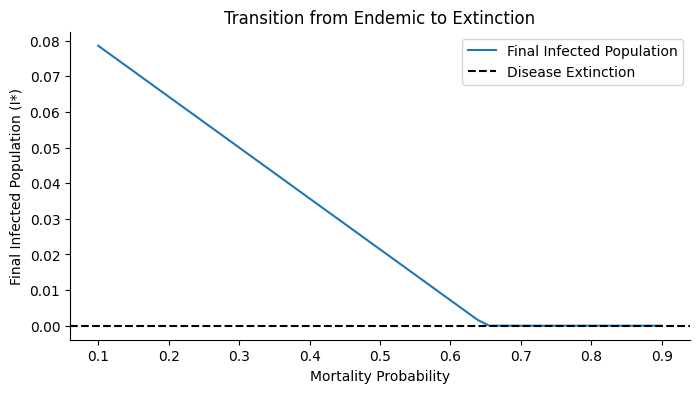

In [123]:

# Function to simulate the model for different mortality probabilities
def plot_endemic_to_extinct(beta, gamma, I0, birth_rate, mortality_probabilities, t):
    final_infected = []
    
    for mort_prob in mortality_probabilities:
        model = SIRmortality(beta, gamma, I0, birth_rate, mort_prob)
        T, S, I, R = model.numerical_integration(t)
        final_I = I[-1]  # The final infected population
        final_infected.append(final_I)
    
    # Plot the results
    plt.figure(figsize=(8, 4))  # Adjust the width and height to make it less tall
    plt.plot(mortality_probabilities, final_infected, label='Final Infected Population')
    plt.xlabel('Mortality Probability')
    plt.ylabel('Final Infected Population (I*)')
    plt.title('Transition from Endemic to Extinction')
    plt.axhline(0, color='black', linestyle='--', label='Disease Extinction')
    plt.grid(False)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.legend()
    plt.savefig("mortsir.png", dpi=300)
    plt.show()

# Example usage
mortality_probabilities = np.linspace(0.1, 0.9, 50)  # Testing a range of mortality probabilities
plot_endemic_to_extinct(beta=1, gamma=0.3, I0=0.1, birth_rate=1/20, mortality_probabilities=mortality_probabilities, t=500)


## SEIRS model

In this section, we introduce a custom extension of SIR, SEIRS. A new compartment is introduced, $E$, which stands for Exposure. For many infectious agents, there is a latiency period before becoming infectious. Therefore, those hosts are neither Susceptible nor Infectious. In the SEIRS framework, these individuals are placed in $E$. Firstly, we investigate a basic implementation of SEIRS using the paramater values from Bjornstad et al. (2020) [4].


In [124]:
# Update the temperature function to reflect realistic seasonal variations, with T0 representing the average temperature
class SEIRS:
    def __init__(self, beta: float, gamma: float, sigma: float, I0: float, E0: float, A0: float, T0: float, mu: float, omega: float):
        self.beta = beta       # Base transmission rate
        self.gamma = gamma     # Recovery rate
        self.sigma = sigma     # Incubation rate (E -> I)
        self.mu = mu           # Birth/Death rate
        self.omega = omega     # Waning immunity rate
        self.S = 1 - I0 - E0   # Initial susceptible population (assuming R0 = 0 initially)
        self.E = E0            # Initial exposed population
        self.I = I0            # Initial infected population
        self.R = 0             # Initial recovered population
        self.A0 = A0           # Seasonal forcing amplitude
        self.T0 = T0           # Average temperature parameter

    # Sinusoidal seasonal temperature forcing, where T0 is the average temperature
    def temperature(self, t):
        # Sinusoidal temperature variation over a year with a seasonal shift
        t_temp = int(t // 1) % 365 + 1
        return self.T0 + self.T0 * np.sin(2 * np.pi * (t_temp / 365 - 0.25))

    # Transmission rate that increases in colder conditions
    def beta_t(self, t):
        T_t = self.temperature(t)
        return self.beta + self.beta * self.A0 * (1 - T_t / self.T0)  # Transmission inversely related to temperature (increases in cold)

    # Susceptible population differential equation (now includes waning immunity)
    def dSdt(self, S, I, R, t):
        beta_t = self.beta_t(t)
        return self.mu - beta_t * S * I + self.omega * R - self.mu * S # Waning immunity term added

    # Exposed population differential equation
    def dEdt(self, S, I, E, t):
        beta_t = self.beta_t(t)
        return beta_t * S * I - (self.sigma + self.mu) * E

    # Infected population differential equation
    def dIdt(self, E, I):
        return self.sigma * E - (self.gamma + self.mu) * I

    # Recovered population differential equation (now includes loss of immunity)
    def dRdt(self, I, R):
        return self.gamma * I - (self.mu + self.omega) * R  # Waning immunity term added

    # Update step using RK4 method
    def update_step(self, t, dt=0.01):
        delta_S = RK4(self.dSdt, (self.S, self.I, self.R, t), step_size=dt)
        delta_E = RK4(self.dEdt, (self.S, self.I, self.E, t), step_size=dt)
        delta_I = RK4(self.dIdt, (self.E, self.I), step_size=dt)
        delta_R = RK4(self.dRdt, (self.I, self.R), step_size=dt)
        
        self.S += delta_S
        self.E += delta_E
        self.I += delta_I
        self.R += delta_R

    # Numerical integration over time
    def numerical_integration(self, t: int, dt: float = 0.01):
        times = np.linspace(0, t, int(t / dt) + 1)
        S_values = [self.S]
        E_values = [self.E]
        I_values = [self.I]
        R_values = [self.R]

        for time in times[1:]:
            self.update_step(time, dt)
            S_values.append(self.S)
            E_values.append(self.E)
            I_values.append(self.I)
            R_values.append(self.R)

        return np.column_stack((times, S_values, E_values, I_values, R_values)).T


We create a temperature and transmission rate plot, which is used in the background section of the report.

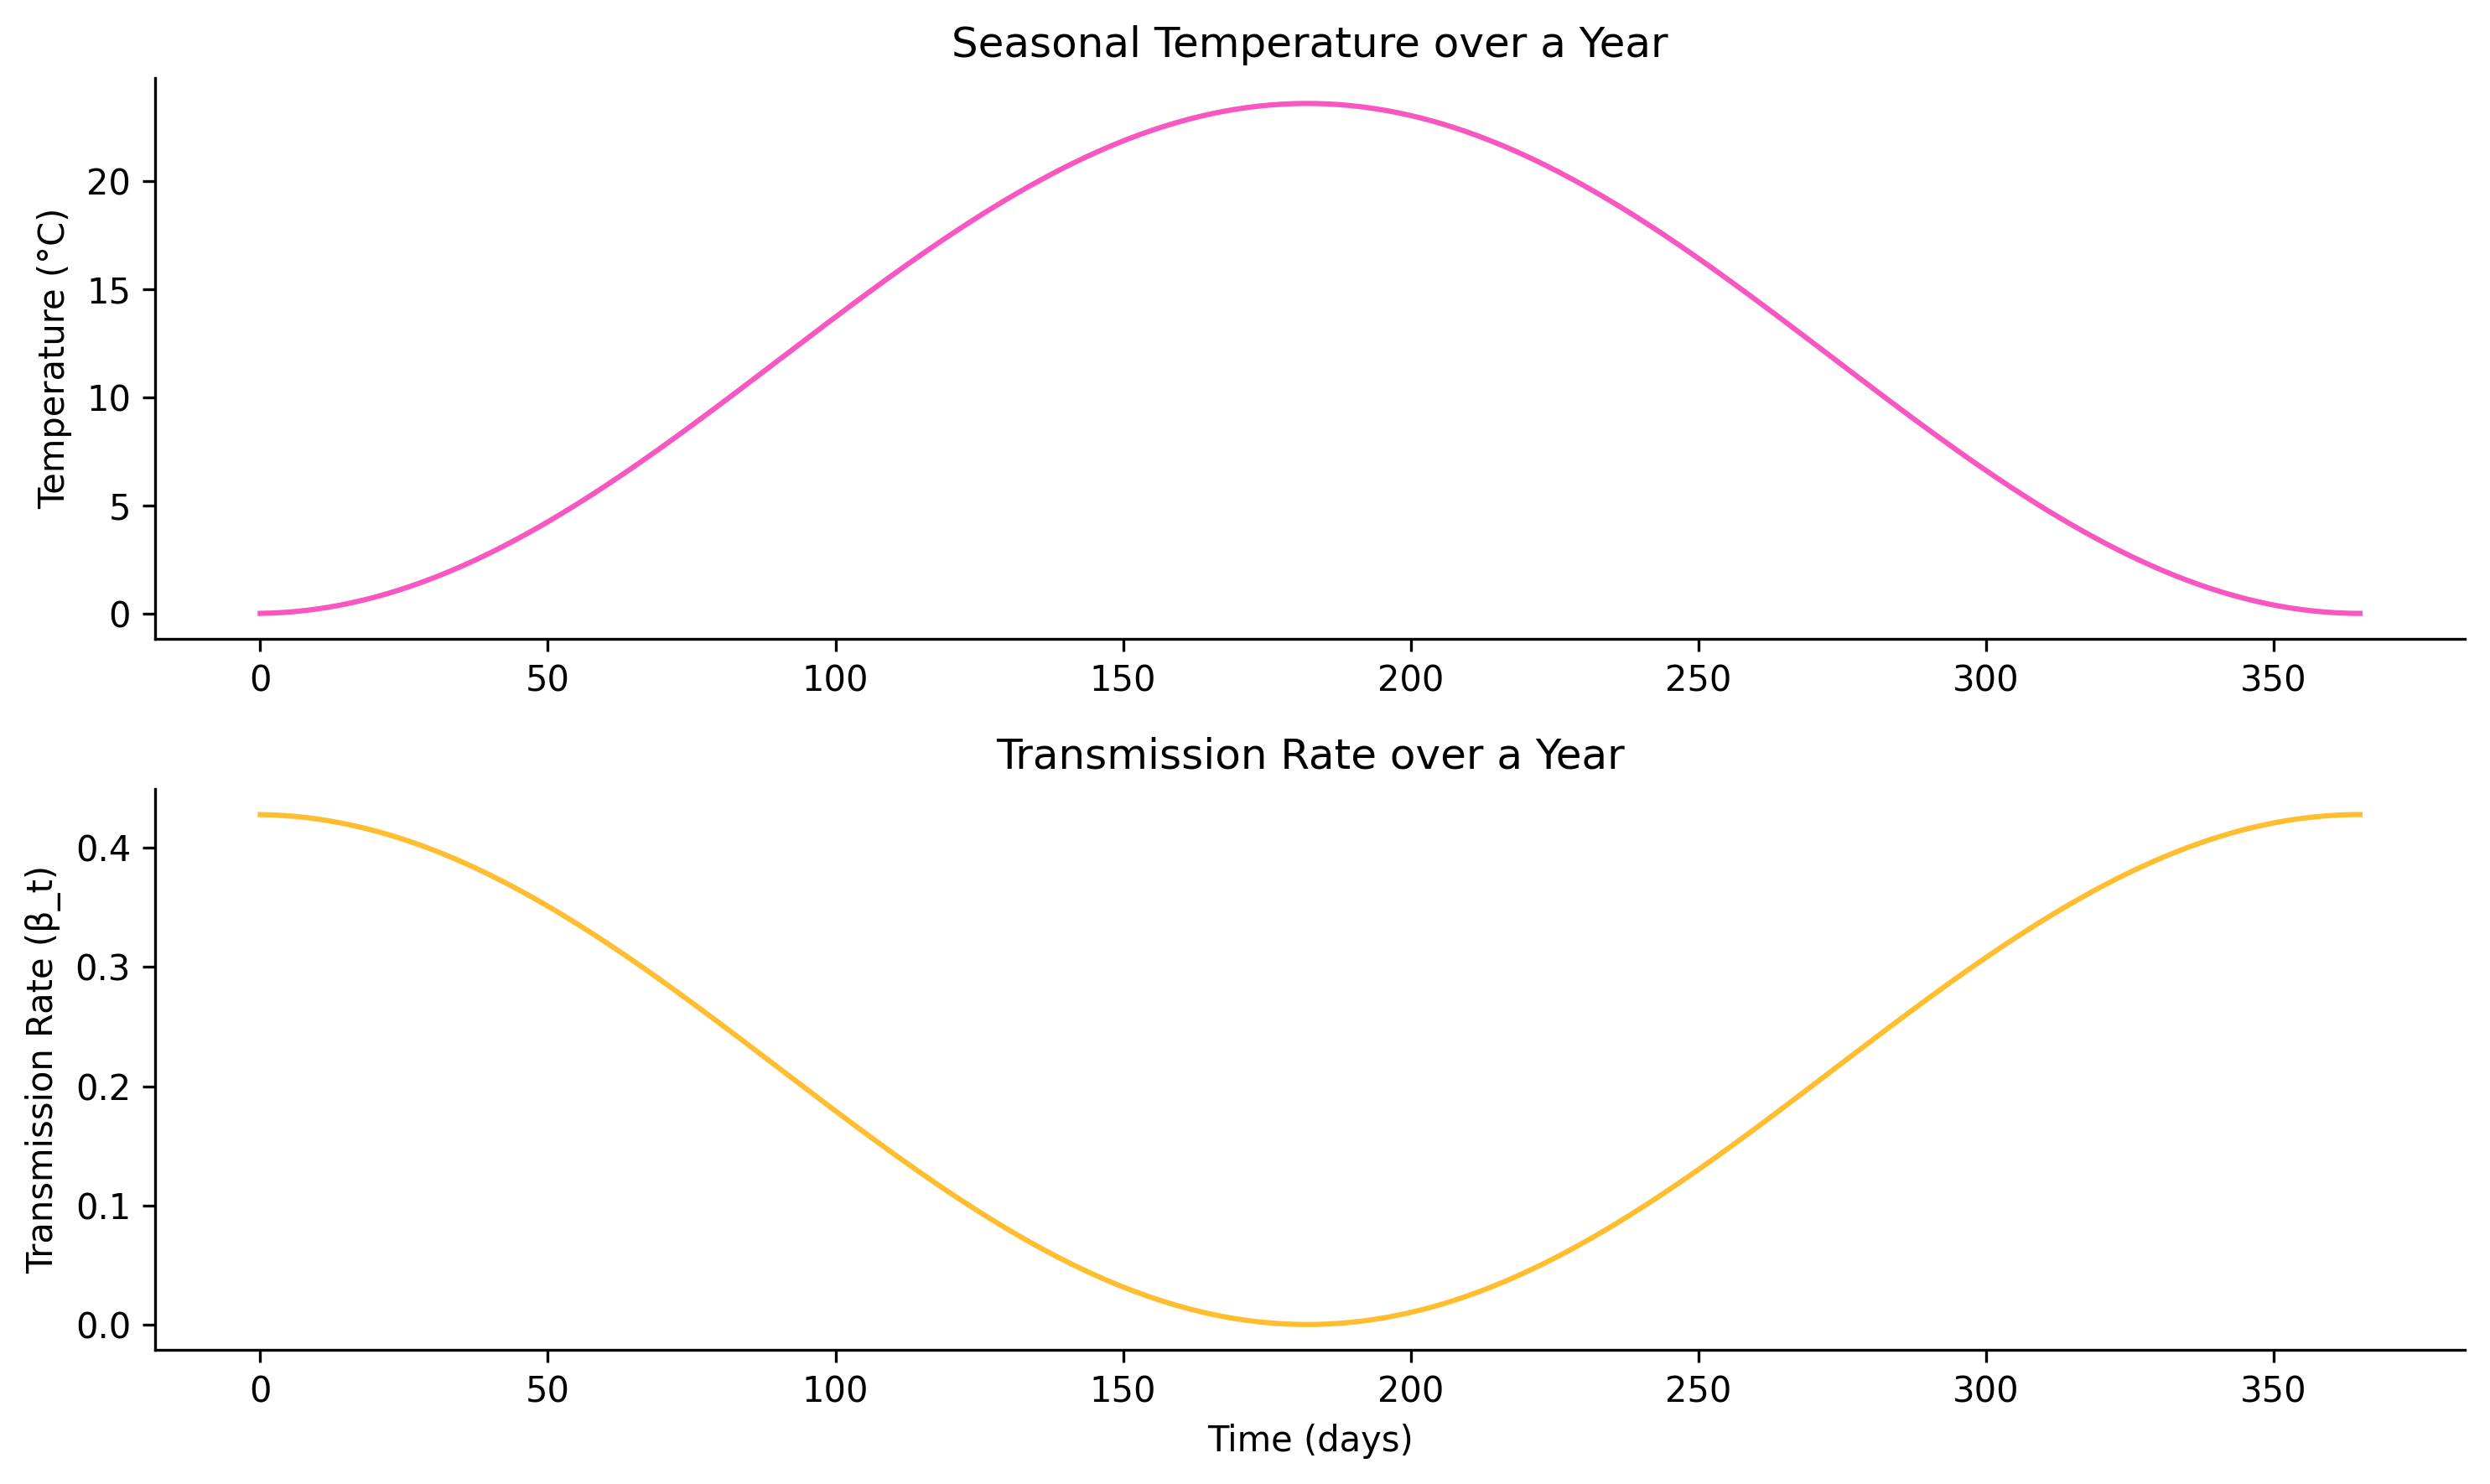

In [134]:
# Function to plot temperature and transmission rate over time
def plot_temperature_and_transmission(model, days=365):
    time_points = np.linspace(0, days, days)

    # Collect temperature and transmission values over time
    temperature_values = [model.temperature(t) for t in time_points]
    transmission_values = [model.beta_t(t) for t in time_points]

    # Plot temperature and transmission over time
    plt.figure(figsize=(10, 6), dpi = 300)

    plt.subplot(2, 1, 1)
    plt.plot(time_points, temperature_values, label="Temperature (°C)", color=colors["Recovered"])
    plt.title("Seasonal Temperature over a Year")
    plt.ylabel("Temperature (°C)")
        
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.grid(False)

    plt.subplot(2, 1, 2)
    plt.plot(time_points, transmission_values, label="Transmission Rate (β_t)", color=colors["Susceptible"])
    plt.title("Transmission Rate over a Year")
    plt.ylabel("Transmission Rate (β_t)")
    plt.xlabel("Time (days)")
    plt.grid(False)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.savefig("tempovertime.png", dpi = 300)



A0=1
# Initialize the SEIR model for the common cold
seirs_model = SEIRS(beta, gamma, sigma, I0, E0, A0, T0, mu, omega)

# Example usage:
plot_temperature_and_transmission(seirs_model)

<Figure size 1000x600 with 0 Axes>

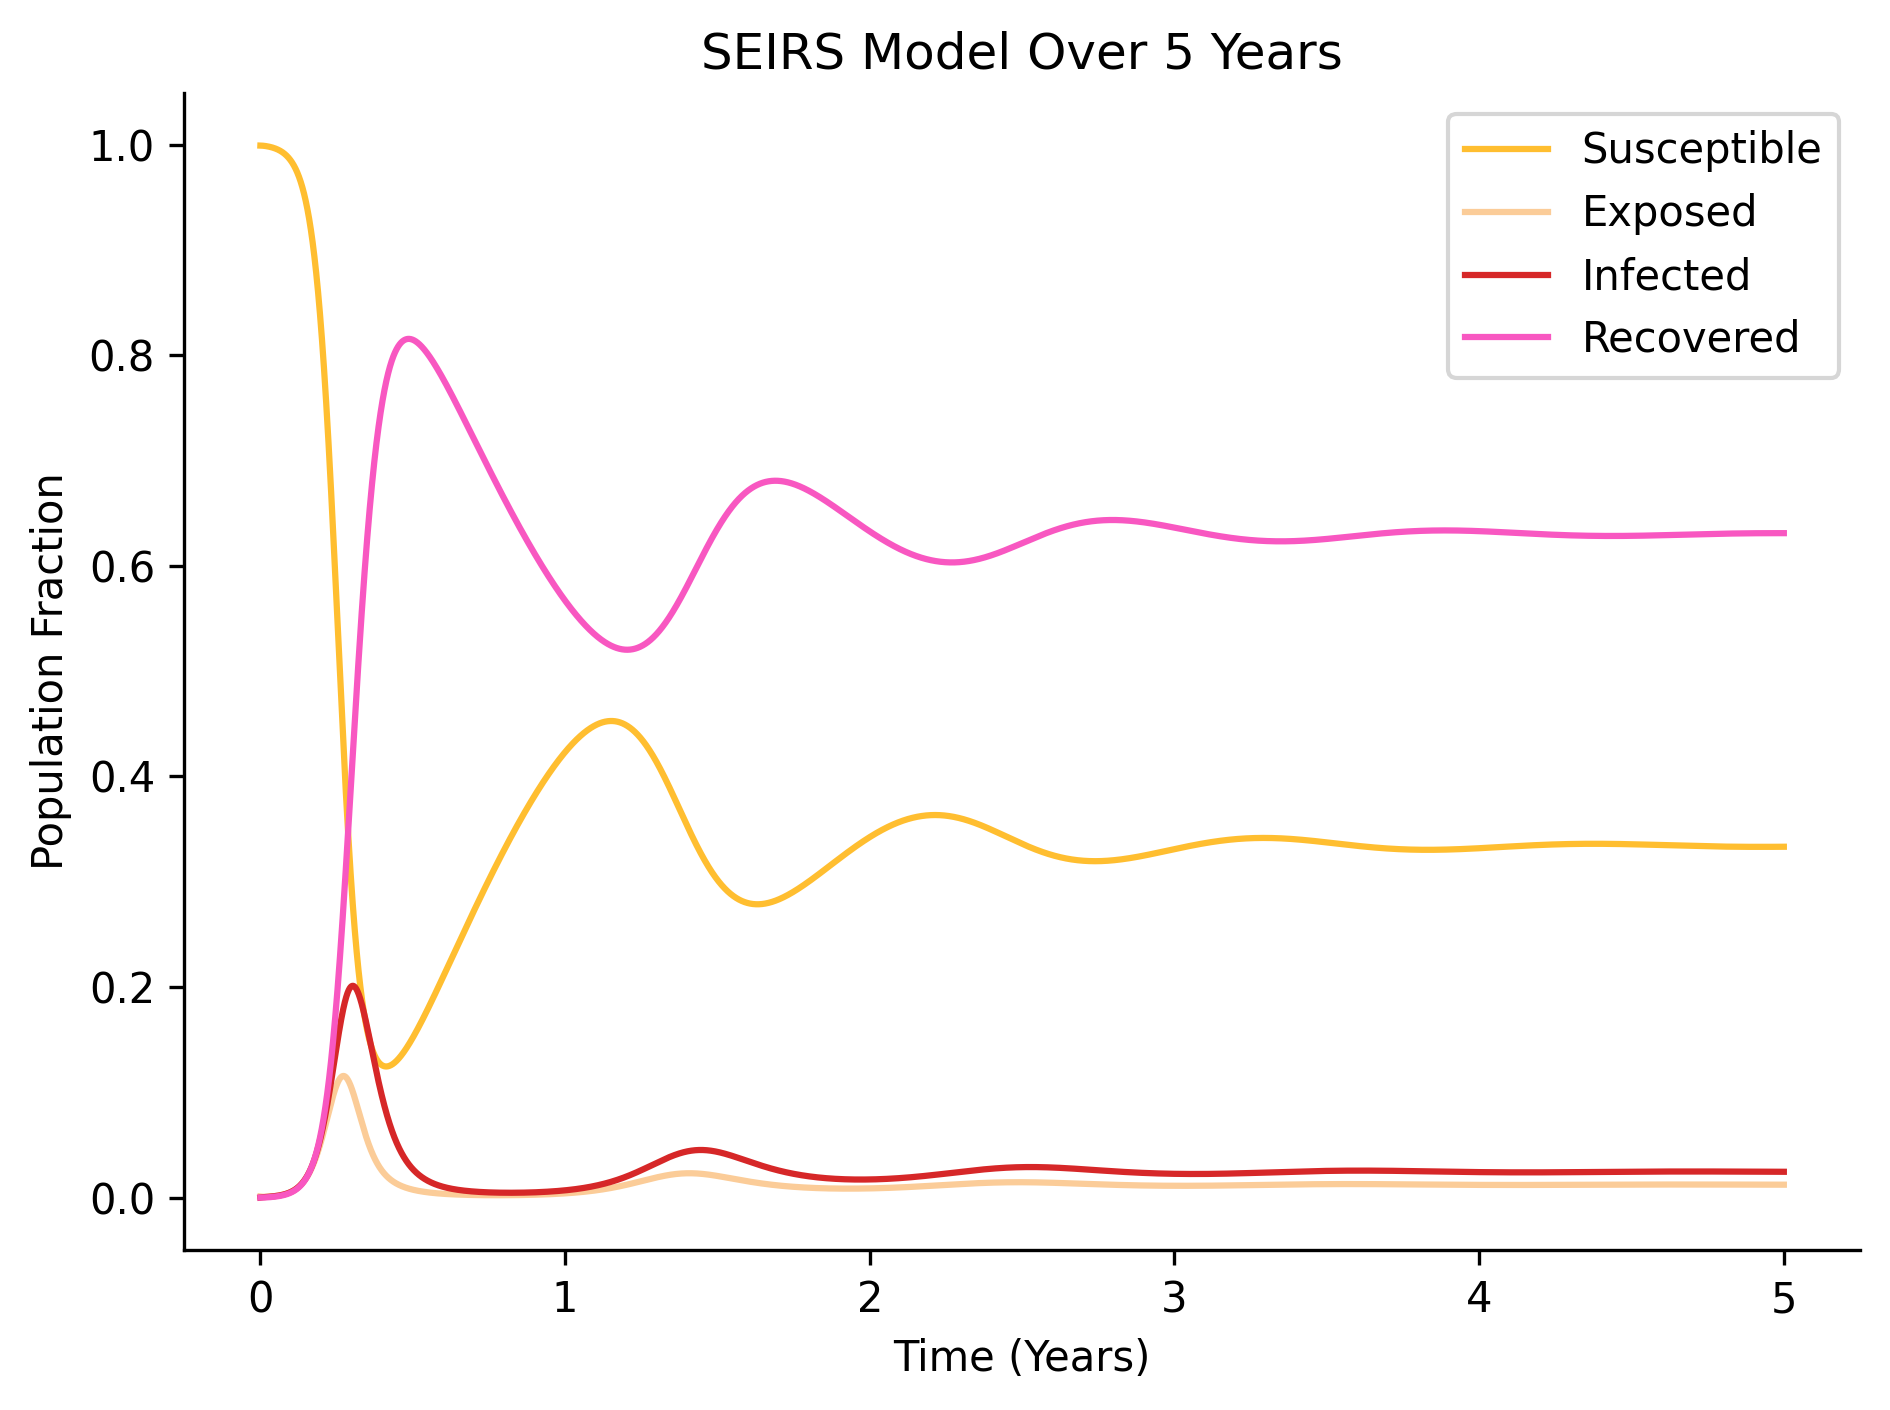

In [125]:

beta = 0.214      # Base transmission rate
gamma = 1/14      # Recovery rate
sigma = 1/7      # Incubation rate
I0 = 0       # Initial infected population
E0 = 0.001        # Initial exposed population
A0 = 0      # Seasonal forcing amplitude
T0 = 11.8           # Average temperature
mu = 1 / (76*365)      # Birth/Death rate (average lifespan of 76 years)
omega = 1/365

# Initialize the SEIR model for the common cold
seirs_model = SEIRS(beta, gamma, sigma, I0, E0, A0, T0, mu, omega)

# Run the model over 365 days (5 year)
T, S, E, I, R = seirs_model.numerical_integration(t=365*5, dt=0.01)


# Extract time, S, E, I, R values from the results
time = T/365



# Plot the results
plt.figure(figsize=(10, 6))
plt.figure(dpi=300)
plt.plot(time, S, label='Susceptible',  color = colors["Susceptible"])
plt.plot(time, E, label='Exposed',  color = colors["Exposed"])
plt.plot(time, I, label='Infected',  color = colors["Infected"])
plt.plot(time, R, label='Recovered',  color = colors["Recovered"])

plt.title('SEIRS Model Over 5 Years')
plt.xlabel('Time (Years)')
plt.ylabel('Population Fraction')
plt.legend()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.grid(False)
plt.show()

We create a phase diagram for the SEIRS model to show how the SEIRS model reaches an equilibrium without seasonal forcing. We do this for different values of omega. We use the log scale in order to see the trajectory of the SEIRS models with slow waning immunity properly


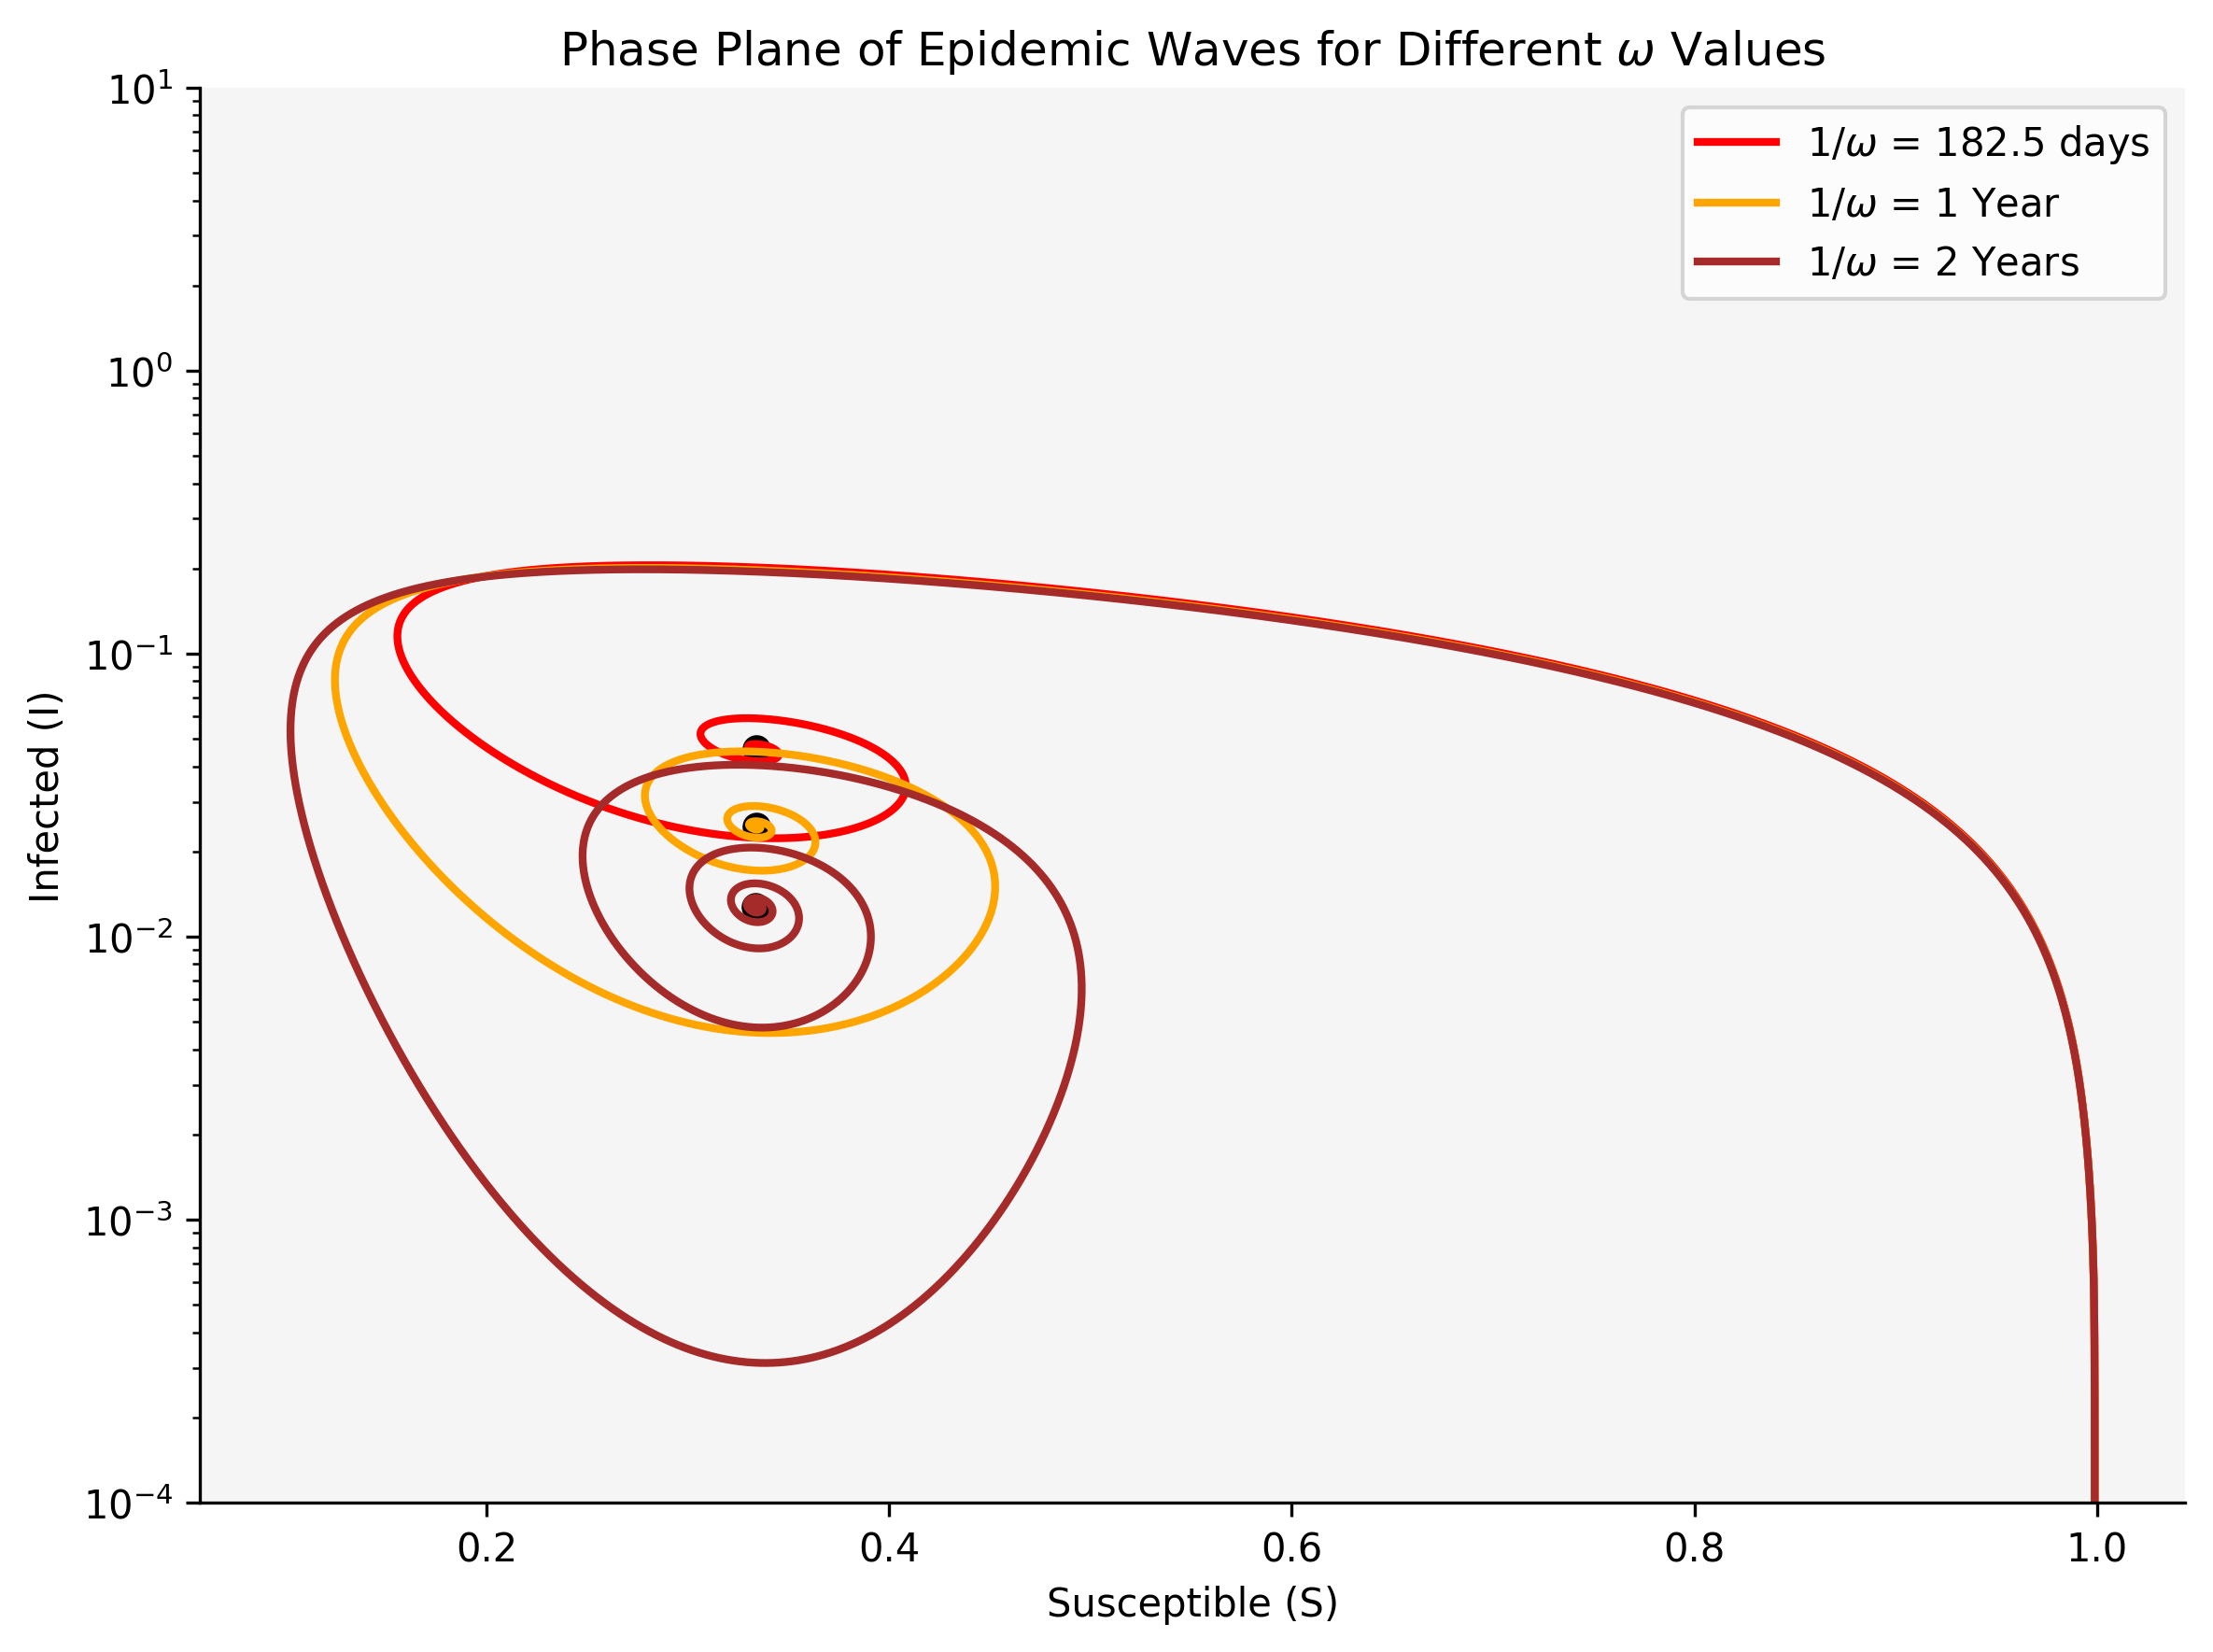

In [127]:
# Define a range of omega values to test
omega_values = [1/(365/2), 1/(365), 1/(365*2)]  # Example values for different rates of waning immunity
omega_labels = [r'1/$\omega$ = 182.5 days', r'1/$\omega$ = 1 Year', r'1/$\omega$ = 2 Years']
colors_list = ['red', 'orange', 'brown']  # Assign distinct colors for different omega values

# Create a figure for the phase diagram
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

# Loop through the different omega values and plot on the same axes
for i, omega in enumerate(omega_values):
    # Initialize the SEIRS model with the current omega value
    seir_model = SEIRS(beta=beta, gamma=gamma, sigma=sigma, I0=I0, A0=0, T0=11.8, mu=mu, omega=omega, E0=E0)
    
    # Run the model for a fixed time period (e.g., 5 years)
    T, S, E, I, R = seir_model.numerical_integration(t=365 * 10, dt=0.01)
    
    # Plot phase plane: S vs I for the current omega value
    ax.plot(S, I, color=colors_list[i], lw=2, label=omega_labels[i])
    
    # Plot steady-state points (S∞, I∞) as black dots
    ax.scatter(S[-1], I[-1], color='black', s=40)

# Set the title and labels
ax.set_title("Phase Plane of Epidemic Waves for Different $\\omega$ Values", fontsize=12)
ax.set_xlabel("Susceptible (S)")
ax.set_ylabel("Infected (I)")
ax.set_yscale('log')
ax.set_ylim(1e-4, 1e1)  # Set appropriate y-axis limits for better visibility
plt.gca().set_facecolor("whitesmoke")
# Add a legend to distinguish the different omega values
ax.legend(loc='upper right')

# Add grid, customize spines, and set the x-axis to focus on the range
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)

# Save and show the plot
plt.tight_layout()
plt.savefig("phase_plane_combined_omega.png", dpi=300)
plt.show()


The final plot of the report combines the SEIRS model plots for different levels of seasonal forcing with a Fourier analysis to show the oscillatory behavior.

Period: 405.56 years
Period: 365.00 years
Period: 365.00 years


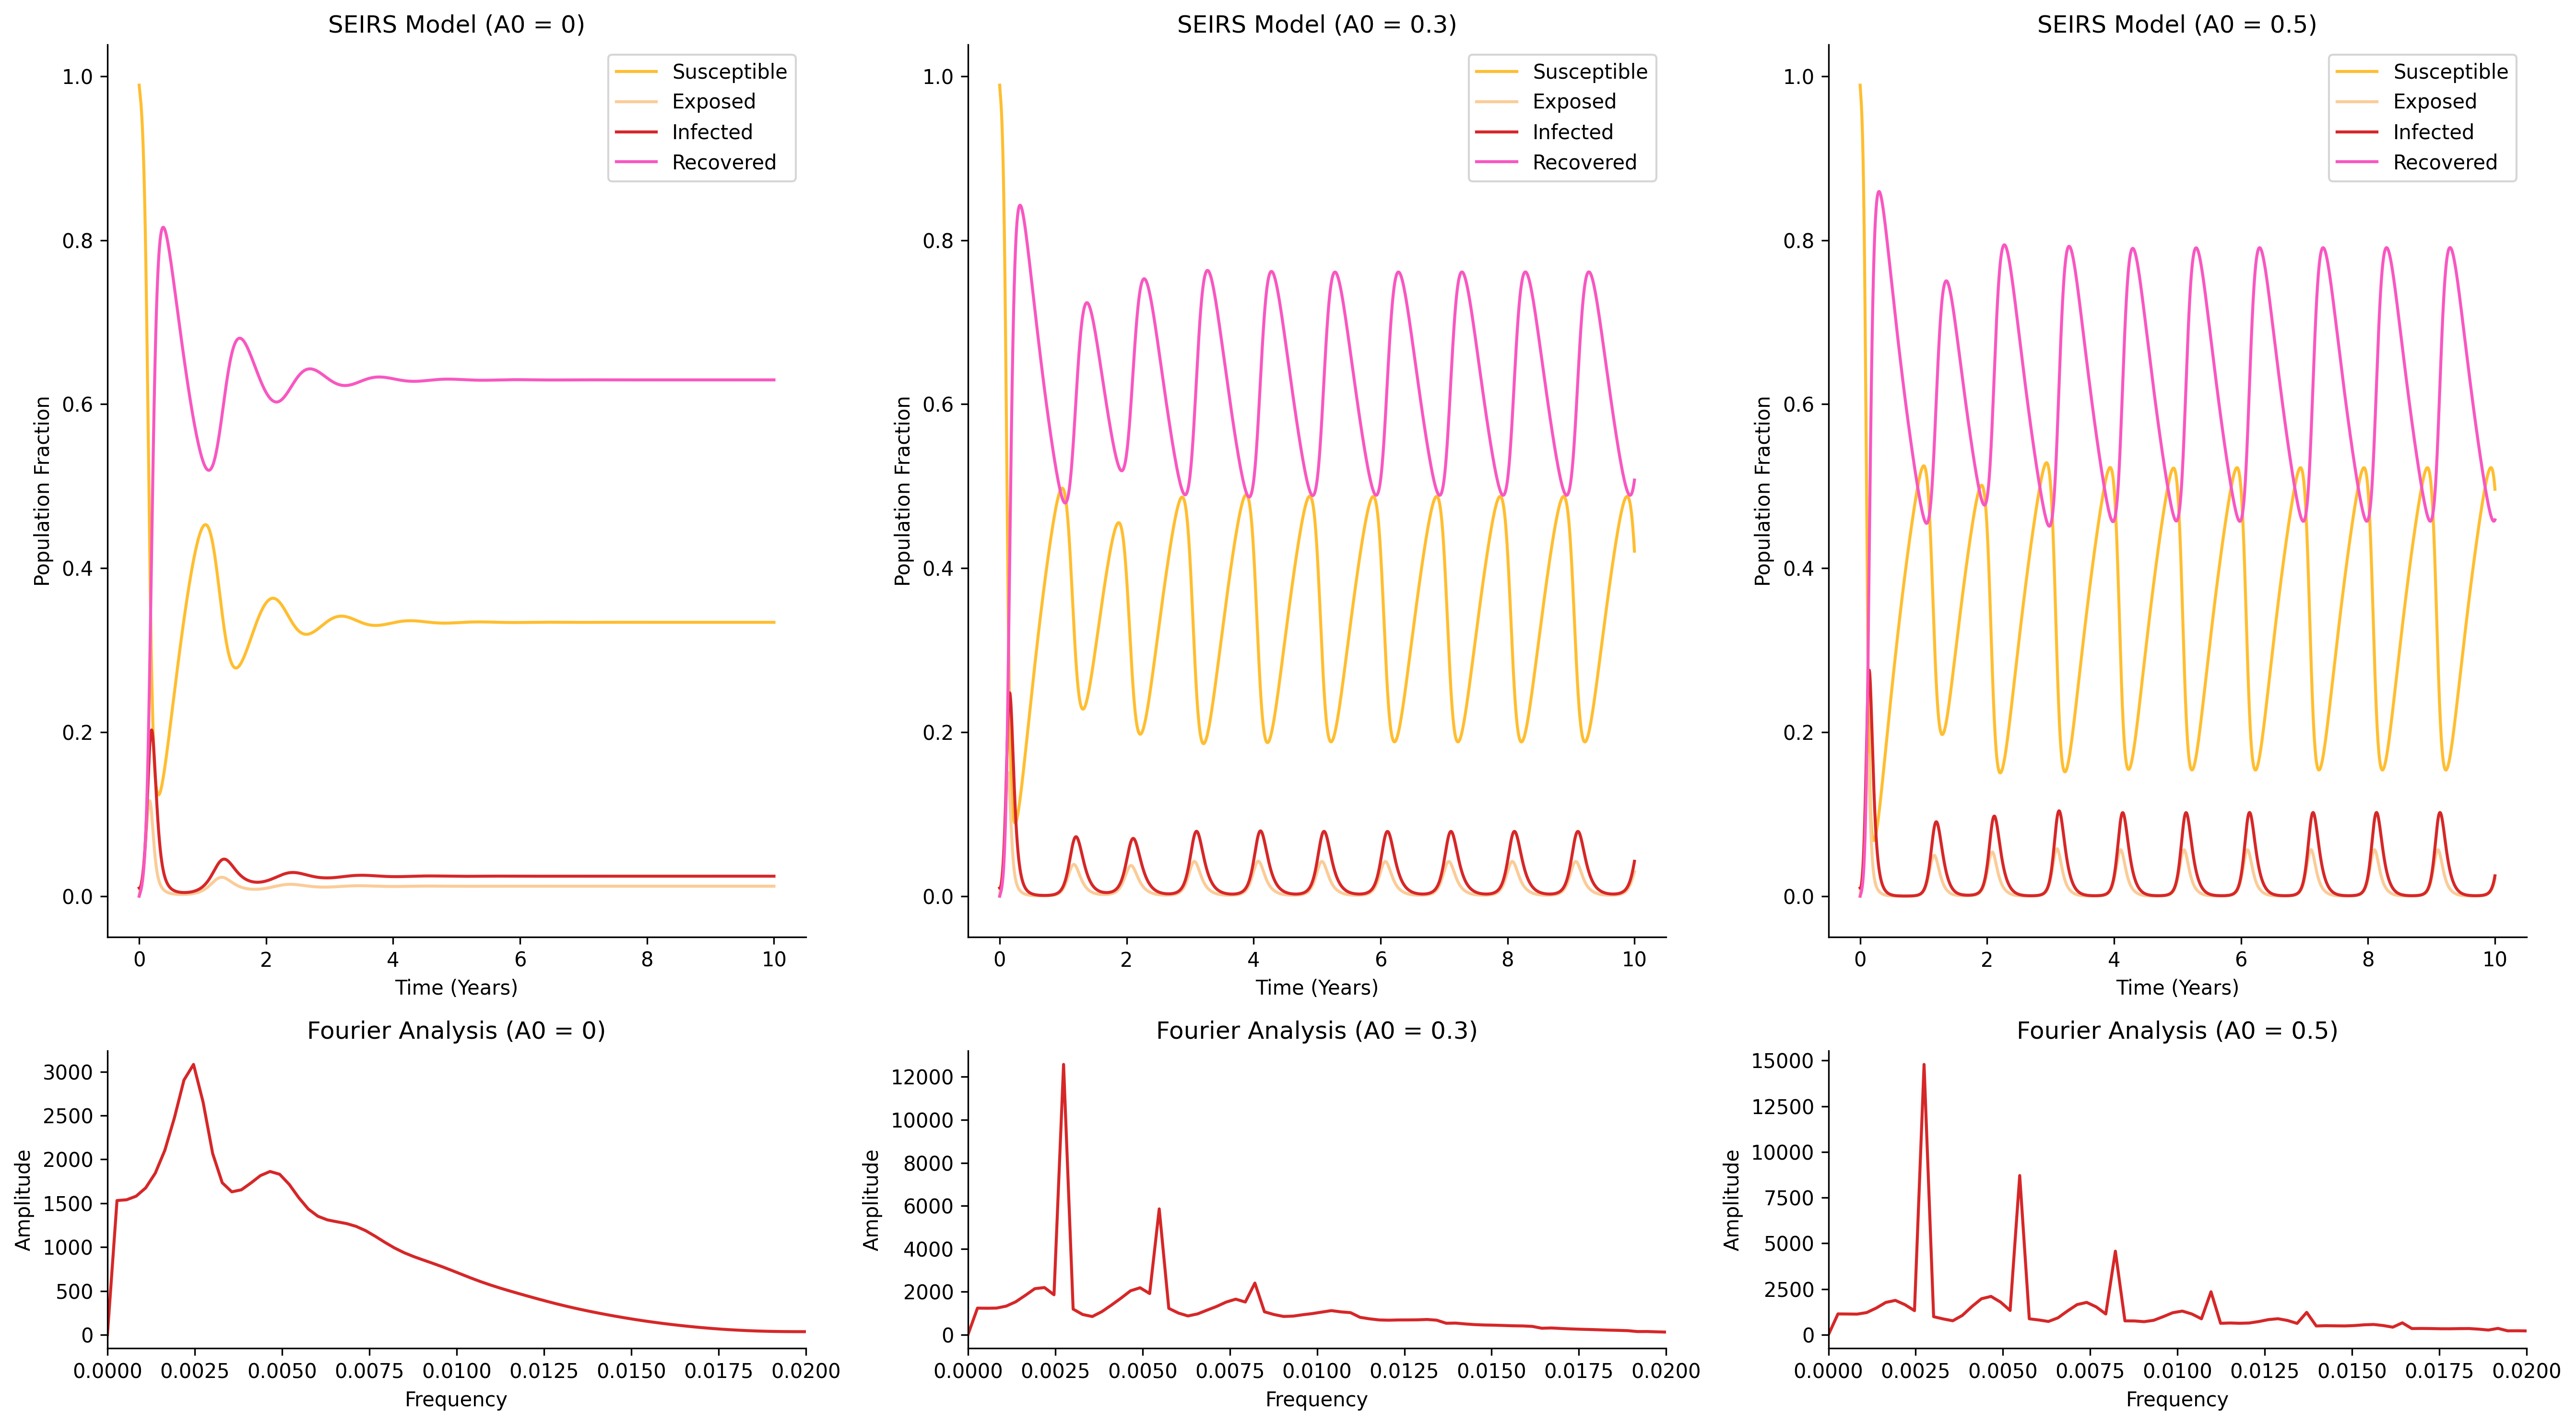

In [132]:

# Plot function for SEIRS model and Fourier analysis
def plot_seirs_with_fourier(A0_values):
    fig, axs = plt.subplots(2, 3, figsize=(18, 10), dpi=300, gridspec_kw={'height_ratios': [3, 1]}) # 2 rows, 3 columns with custom dpi

    # Parameters and model initialization (example)
    beta = 0.214      # Base transmission rate
    gamma = 1/14      # Recovery rate
    sigma = 1/7      # Incubation rate
    I0 = 0.01       # Initial infected population
    E0 = 0.001        # Initial exposed population
    T0 = 11.8           # Average temperature
    mu = 1 / (76*365)      # Birth/Death rate (average lifespan of 76 years)
    omega = 1/365
    simulation_time = 365 * 10  # 10 years
    dt = 0.005


    for i, A0 in enumerate(A0_values):
        seirs_model = SEIRS(beta=beta, gamma=gamma, sigma=sigma, I0=I0, E0=E0, A0=A0, T0=T0, mu=mu, omega=omega)
        t, S, E, I, R = seirs_model.numerical_integration(simulation_time, dt)
        times = t/365
        
        # Plot SEIRS time series (focus on I) in the top row
        axs[0, i].plot(times, S, label='Susceptible', color=colors["Susceptible"])
        axs[0, i].plot(times, E, label='Exposed', color=colors["Exposed"])
        axs[0, i].plot(times, I, label='Infected', color=colors["Infected"])
        axs[0, i].plot(times, R, label='Recovered', color=colors["Recovered"])

        axs[0, i].set_title(f'SEIRS Model (A0 = {A0})')
        axs[0, i].set_xlabel('Time (Years)')
        axs[0, i].set_ylabel('Population Fraction')
        axs[0, i].legend()

        # Remove top and right spines
        axs[0, i].spines['top'].set_visible(False)
        axs[0, i].spines['right'].set_visible(False)
        axs[0, i].grid(False)

        # Fourier Analysis of Infectious Population

        n = len(t)  # Length of the data
        fourier = fft.fft(I - np.mean(I))
        freqs = fft.fftfreq(n, d=dt)  # Correctly compute frequencies based on time step

        # Consider only positive frequencies
        positive_freqs = freqs[freqs >= 0]
        abs_fourier = np.abs(fourier[:len(positive_freqs)])  

        # Find the dominant frequency (frequency with highest amplitude)
        dominant_frequency_index = np.argmax(abs_fourier)
        dominant_frequency = positive_freqs[dominant_frequency_index]

        # Compute oscillating period
        if dominant_frequency > 0:
            oscillating_period = 1 / dominant_frequency
            print(f'Period: {oscillating_period:.2f} years')
 
        # Plot Fourier transform in the bottom row
        axs[1, i].plot(positive_freqs, abs_fourier, color=colors["Infected"])
        axs[1, i].set_title(f'Fourier Analysis (A0 = {A0})')
        axs[1, i].set_xlabel('Frequency')
        axs[1, i].set_ylabel('Amplitude')
        axs[1, i].set_xlim(0.0, 0.02)  # Adjust the x-axis limit to focus on the range of interest

        axs[1, i].spines['top'].set_visible(False)
        axs[1, i].spines['right'].set_visible(False)
        axs[1, i].grid(False)
    plt.tight_layout()
    plt.savefig("effects_of_seasonality.png")
    plt.show()



# Define seasonal forcing amplitude values to simulate
A0_values = [0, 0.3, 0.5]  # Different levels of seasonal forcing

# Generate the plots
plot_seirs_with_fourier(A0_values)

## References

[1] W. H. Press, S. A. Teukolsky, W. T. Vetterling, and B. P. Flannery, Numerical Recipes 3rd Edition: The Art of Scientific Computing, 3rd ed. USA: Cambridge University Press, 2007.

[2] M. J. Keeling and P. Rohani, Modeling Infectious Diseases in Humans and Animals. Princeton University Press, 2008.

[3] T. H. Cormen, C. E. Leiserson, R. L. Rivest, and C. Stein, Introduction to Algorithms, Third Edition, 3rd ed. The MIT Press, 2009.

[4] Bjørnstad, O.N., Shea, K., Krzywinski, M. et al. The SEIRS model for infectious disease dynamics. Nat Methods 17, 557–558 (2020). https://doi.org/10.1038/s41592-020-0856-2